# Shear profile around A360 using ComCam HSM shapes - Manual

Prakruth Adari, Céline Combet, Anja von der Linden\
LSST Science Piplines version: Weekly 2025_30\
Container Size: large

This notebook goes over the necessary steps to create the source sample for the Abell 360 Weak Lensing project. A rough outline of the steps are:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Applying cuts (color/photo-z + lensing quality)
- Load in calibration (using the `gen_hsc_calibration` script)
- Shear profile

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.stats as stats
import healpy as hp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from astropy.visualization import make_lupton_rgb
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
from astropy.table import Table, join, vstack
from astropy.io import fits
import healsparse as hsp
from astropy.coordinates import SkyCoord
# %matplotlib widget
import h5py
import qp

In [2]:
# Familiar stack packages
from lsst.daf.butler import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
# from lsst.afw.image import Exposure, Image, PARENT
import lsst.sphgeom

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage

In [3]:
# import lsst.afw.display as afwDisplay
import os, sys, gc
import functools
import pickle

In [4]:
# !pip install clmm

In [5]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [6]:
hdir = os.getenv('HOME')
ddir = '/home/a/adari/DATA'
outdir = '/home/a/adari/u/clusters/cluster_data'
# outdir = '/global/cfs/cdirs/lsst/groups/CL/A360_DP1/source_selection_scratch/'

In [7]:
# Running at USDF RSP?
pz_sv38_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ecdfs_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
# pz_sv38_pdf_dir = '/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/'
pz_ecdfs_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all'
pz_sv38_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38'

# Running at NERSC?
# pz_sv38_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_4band'
# pz_ecdfs_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_6band'

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
def showRGB(image, bgr="gri", ax=None, fp=None, figsize=(8,8), stretch=57, Q=10):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    fp: `lsst.afw.detection.Footprint`
        Footprint that contains the peak catalog for peaks in the image.
        If `fp` is `None` then no peak positions are plotted.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,  # numpy array for the r channel
                          image_g=image[bgr[1]].array,  # numpy array for the g channel
                          image_b=image[bgr[0]].array,  # numpy array for the b channel
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = image[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    ax.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))
    if fp is not None:
        for peak in fp.getPeaks():
            ax.plot(peak.getIx(), peak.getIy(), "bx", mew=2)

In [10]:
# QOL Functions to make cubehelix colormaps

import matplotlib as mpl
import matplotlib.colors as mcolors


def _reverser(func, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    return func(1 - x)

def reversed(cmap):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_r = {
        key: (functools.partial(_reverser, data))
        for key, data in cmap._segmentdata.items()}

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_r,
        cmap.N,
        cmap._gamma,
    )

    # Reverse the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def _truncator(func, light, dark, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    if (light > 1) or (light < 0):
        raise ValueError(f"light {light} not in [0, 1]")
    if (dark > 1) or (dark < 0):
        raise ValueError(f"dark {dark} not in [0, 1]")

    return func(x * (light - dark) + dark)


def truncated(cmap, light, dark):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_t = {
        key: (functools.partial(_truncator, data, light, dark))
        for key, data in cmap._segmentdata.items()
    }

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_t,
        cmap.N,
        cmap._gamma,
    )

    # Truncate the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def cubehelix_colormap(
    *,
    start=None,
    rot=None,
    gamma=None,
    hue=None,
    light=1,
    dark=0,
    name=None,
    reverse=False,
):
    """
    cubehelix color scheme by Dave Green (https://people.phy.cam.ac.uk/dag9/CUBEHELIX/)
    """
    # Note: this relies on an internal matplotlib function, so may need to be
    # updated in the future
    cdict = mpl._cm.cubehelix(gamma=gamma, s=start, r=rot, h=hue)

    cmap = mcolors.LinearSegmentedColormap(name, cdict)

    cmap = truncated(cmap, light, dark)

    if reverse:
        cmap = reversed(cmap)

    return cmap

def cubehelix_palette(
    n_colors=6,
    start=0,
    rot=0.4,
    gamma=1.0,
    hue=0.8,
    light=0.85,
    dark=0.15,
    reverse=False,
):
    cmap = cubehelix_colormap(
        start=start,
        rot=rot,
        gamma=gamma,
        hue=hue,
        light=light,
        dark=dark,
        name=None,
        reverse=reverse,
    )

    x = np.linspace(0, 1, n_colors)
    palette = cmap(x)[:, :3].tolist()

    return palette

In [11]:
rng = np.random.default_rng()

In [12]:
arcsec = 1/60**2

In [13]:
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
C = 3e5 # km/s

In [14]:
Hz = lambda z : C/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [15]:
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

In [16]:
pz_algos = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']

In [17]:
bands = list('griz')
cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]
psf_bands = [b+suffix for b in bands for suffix in ['_psfFlux', '_psfFluxErr',  '_psfFlux_flag']]
extended_bands = [b+'_extendedness' for b in bands]

object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId', 'parentObjectId',
                   'shape_flag', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
                   'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
                   'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2', 'i_ixx', 'i_ixy', 'i_iyy',
                   'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + cmodel_bands + gaap_bands + extended_bands + psf_bands

## Functions

It's helpful to have all the relevant functions defined in once place instead of scattered throughout the entire notebook.

In [18]:
def preclean_filt(preclean_table):
    clean_filt = np.logical_and.reduce((~preclean_table['i_iPSF_flag'], ~preclean_table['i_hsmShapeRegauss_flag'],
                                        ~preclean_table['shape_flag'], ~np.isnan(preclean_table['refExtendedness']),
                                        ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                        ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
    return clean_filt

def preclean_flux_filt(preclean_table):
    clean_filt = np.logical_and.reduce((~np.isnan(preclean_table['refExtendedness']), ~preclean_table['shape_flag'],
                                    ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                    ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
    return clean_filt

In [19]:
def apply_redsequence(table, mag_lim = 23.5, bright_lim=18, delta=0.05):
    
    gi_table_line = (table['i_cModel_mag'] - 18) * (-0.2/5) + 1.9
    ri_table_line = (table['i_cModel_mag'] - 18) * (-0.1/5) + .55
    gr_table_line = (table['i_cModel_mag'] - 18) * (-0.25/5) + 1.35
    
    gi_lims = (0.1, -.25)
    ri_lims = (0.04, -0.08)
    gr_lims = (0.1, -.15)

    table['gi'] = table['g_gaap_mag'] - table['i_gaap_mag']
    table['gr'] = table['g_gaap_mag'] - table['r_gaap_mag']
    table['ri'] = table['r_gaap_mag'] - table['i_gaap_mag']

    gi_redseq = np.logical_and.reduce((table['gi'] < gi_table_line + gi_lims[0] + delta, table['gi'] > gi_table_line + gi_lims[1] - delta,
                                   table['i_cModel_mag'] < 28, table['i_cModel_mag'] > bright_lim))
    ri_redseq = np.logical_and.reduce((table['ri'] < ri_table_line + ri_lims[0] + delta, table['ri'] > ri_table_line + ri_lims[1] - delta,
                                       table['i_cModel_mag'] < 28, table['i_cModel_mag'] > bright_lim))
    gr_redseq = np.logical_and.reduce((table['gr'] < gr_table_line + gr_lims[0] + delta, table['gr'] > gr_table_line + gr_lims[1] - delta,
                                       table['i_cModel_mag'] < 28, table['i_cModel_mag'] > bright_lim))

    all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))
    table['all_redseq'] = all_redseq
    # For individual colors we should add a magnitude limit since it's more likely for source galaxies to be located in at least one color
    
    table['gi_redseq'] = np.logical_and(gi_redseq, table['r_cModel_mag'] < mag_lim)
    table['ri_redseq'] = np.logical_and(ri_redseq, table['r_cModel_mag'] < mag_lim)
    table['gr_redseq'] = np.logical_and(gr_redseq, table['r_cModel_mag'] < mag_lim)

    return table
    
def apply_redsequence_noisy(table, mag_lim = 23.5, bright_lim=18, sigma=2, delta=0.05):

    gi_table_line = (table['i_cModel_mag'] - 18) * (-0.2/5) + 1.9
    ri_table_line = (table['i_cModel_mag'] - 18) * (-0.1/5) + .55
    gr_table_line = (table['i_cModel_mag'] - 18) * (-0.25/5) + 1.35

    gi_lims = (0.1 + delta, -.25 - delta)
    ri_lims = (0.04 + delta, -0.08 - delta)
    gr_lims = (0.1 + delta, -.15 - delta)

    gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
    ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
    gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))

    gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
    ri_pos = -2.5*np.log10((table['r_gaap1p0Flux'] + sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
    gr_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] + sigma*table['r_gaap1p0FluxErr']))

    gi_plus = np.maximum(gi_pos, gi_neg)
    ri_plus = np.maximum(ri_pos, ri_neg)
    gr_plus = np.maximum(gr_pos, gr_neg)

    gi_minus = np.minimum(gi_neg, gi_pos)
    ri_minus = np.minimum(ri_neg, ri_pos)
    gr_minus = np.minimum(gr_neg, gr_pos)

    table['gi'] = table['g_gaap_mag'] - table['i_gaap_mag']
    table['ri'] = table['r_gaap_mag'] - table['i_gaap_mag']
    table['gr'] = table['g_gaap_mag'] - table['r_gaap_mag']
    
    table['gi_plus'] = gi_plus
    table['ri_plus'] = ri_plus
    table['gr_plus'] = gr_plus

    table['gi_neg'] = gi_minus
    table['ri_neg'] = ri_minus
    table['gr_neg'] = gr_minus

    rs_table_lines = [gi_table_line, ri_table_line, gr_table_line]
    rs_lims = [gi_lims, ri_lims, gr_lims]
    rs_table_upper = [t+l[0] for t,l in zip(rs_table_lines, rs_lims)]
    rs_table_lower = [t+l[1] for t,l in zip(rs_table_lines, rs_lims)]
    table_plus = [gi_plus, ri_plus, gr_plus]
    table_neg = [gi_minus, ri_minus, gr_minus]

    redsequences = []
    for i,cc in enumerate(['gi', 'ri', 'gr']):
        redseq = np.logical_and.reduce((table[cc] < rs_table_upper[i], table[cc] > rs_table_lower[i],
                                         table['i_cModel_mag'] < 28, table['i_cModel_mag'] > bright_lim))
        redseq_err = np.logical_or.reduce((
                                           np.logical_and.reduce((table_plus[i] > rs_table_upper[i],
                                                                  rs_table_lower[i] < table_neg[i],
                                                                  table_neg[i] < rs_table_upper[i])),
                                           np.logical_and.reduce((table_neg[i] < rs_table_lower[i],
                                                                  rs_table_lower[i] < table_plus[i],
                                                                  table_plus[i] < rs_table_upper[i])),
                                           np.logical_and(table_plus[i] > rs_table_upper[i],
                                                          table_neg[i] < rs_table_lower[i])
                                         ))
        # redseq_err = np.logical_and(table_plus[i] > rs_table_upper[i], table_neg[i] < rs_table_lower[i])
        fin_redseq = np.logical_or(redseq, redseq_err)
        redsequences.append(fin_redseq)


    all_redseq = np.logical_and.reduce(redsequences)
    table['all_redseq'] = all_redseq
    # For individual colors we should add a magnitude limit since it's more likely for source galaxies to be located in at least one color
    
    table['gi_redseq'] = np.logical_and(redsequences[0], table['i_cModel_mag'] < mag_lim)
    table['ri_redseq'] = np.logical_and(redsequences[1], table['i_cModel_mag'] < mag_lim)
    table['gr_redseq'] = np.logical_and(redsequences[2], table['i_cModel_mag'] < mag_lim)

    return table

In [20]:
def get_wlfilt(table, mag_lim=24, bright_lim=20, SNR=10, apply_sep=True, apply_extend=True):
    filt = table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= (table['i_cModel_mag'] <= mag_lim)
    filt &= (table['i_cModel_mag'] >= bright_lim)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= SNR
    filt &= ~(table['i_hsmShapeRegauss_flag'])
    filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    filt &= table['res'] >= 0.3
    # filt &= table['i_blendedness'] <= 0.42
    filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
    filt &= table['i_iPSF_flag']==0
    if apply_sep:
        filt &= table['sep'] < 0.5
    if apply_extend:
        # filt &= table['g_extendedness']==1
        # filt &= table['r_extendedness']==1
        # filt &= table['i_extendedness']==1
        filt &= (table['refExtendedness'] >= 0.5)
    print(f"After WL cuts: {np.sum(filt)}")
    return filt

In [21]:
def get_minimal_wlfilt(table, mag_lim=24, bright_lim=20, SNR=10,
                       apply_sep=True, apply_extend=True,
                       hsm_sigma = 0.4, res=0.3):
    filt = table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= ~(table['i_hsmShapeRegauss_flag'])
    filt &= table['i_iPSF_flag']==0
    filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    
    filt &= (table['i_cModel_mag'] <= mag_lim)
    filt &= (table['i_cModel_mag'] >= bright_lim)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= SNR
    filt &= table['res'] >= res
    filt &= (table['i_hsmShapeRegauss_sigma']<= hsm_sigma) * (0 < table['i_hsmShapeRegauss_sigma'])
    if apply_sep:
        filt &= table['sep'] < 0.5
    if apply_extend:
        filt &= (table['refExtendedness'] >= 0.5)
    print(f"After WL cuts: {np.sum(filt)}")
    return filt

In [22]:
def get_pdfs(algo_type, filt, pz_dir):
    xs = np.linspace(0, 3, 301)

    # for x in qp.iterator('{pz_dir}/output_estimate_{algo_type}.hdf5', chunk_size=50000):
    #     print(x)
    # Need to manually chunk the filter filt to match the size of x but should make this step
    # less memory intensive
    
    pdfs = qp.read(f'{pz_dir}/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [23]:
def load_pz_photomdata(tracts=[10463, 10464, 10704],
                       ddir='/sdf/data/rubin/shared/pz/data/dp1_v29.0.0_gold/',
                       suffix = 'pq',
                       columns=object_req_cols,
                       clean_fn=preclean_flux_filt):
    object_cat = []


    for tract in tracts:
        tract_data = pd.read_parquet(ddir+str(tract)+'/object.' + suffix)
        relevant_data = Table.from_pandas(tract_data[columns])
        object_cat.append(relevant_data)

    preclean_table = vstack(object_cat)

    for b in list('griz'):
        preclean_table[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_cModelFlux'])
        preclean_table[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_gaap1p0Flux'])

    clean_filt = clean_fn(preclean_table)
    full_obj = preclean_table[clean_filt]

    R2 = 1 - (full_obj['i_ixxPSF']+full_obj['i_iyyPSF'])/(full_obj['shape_xx']+full_obj['shape_yy'])
    full_obj['res'] = R2

    full_obj['gi'] = full_obj['g_gaap_mag'] - full_obj['i_gaap_mag']
    full_obj['gr'] = full_obj['g_gaap_mag'] - full_obj['r_gaap_mag']
    full_obj['ri'] = full_obj['r_gaap_mag'] - full_obj['i_gaap_mag']

    c1 = SkyCoord(full_obj['coord_ra']*u.deg, full_obj['coord_dec']*u.deg)
    c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
    sep = c1.separation(c2)
    full_obj['sep'] = sep.deg
    return full_obj, preclean_table

In [24]:
def pz_diffs(table, algos):
    for algo in algos:
        zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])
        table[algo+'_diff'] = zwidth/2
    return None

In [25]:
# bo_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/masks_Rubin_SV_38_7.hs')
# hand_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_maskmap_hsp_1024_16384.fits')
# sfd_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_sfd_map_hsp_1024_16384.fits')

# def get_masks(table):
#     star_mask = ~bo_hsp.get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True)
#     hand_mask = ~hand_hsp.get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True)
#     sfd_mask = sfd_hsp.get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True) <= 0.15
#     mask = star_mask & hand_mask & sfd_mask
#     return mask

mask_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet')
def get_masks(table):
    mask = ~mask_hsp['full_mask'].get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True)
    return mask

ecdfs_hsp = hsp.HealSparseMap.read('/sdf/data/rubin/shared/cluster_commissioning/catalogs/masks_ECDFS.hs')
def ecdfs_mask(table):
    star_mask = ~ecdfs_hsp.get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True)
    return star_mask

## Butler Data

In [26]:
# Running at NERSC? Need to run the next line:
# os.environ['DAF_BUTLER_REPOSITORY_INDEX'] = '/global/cfs/cdirs/lsst/production/gen3/shared/data-repos.yaml'

In [27]:
# Setup the Butler

repo = "dp1" # At USDF RSP
# repo = "/repo/DP1" # At NERSC
collection = "LSSTComCam/DP1"
obs_butler = Butler(repo, collections=collection)
obs_registry = obs_butler.registry
t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [28]:
# Position of the BCG for A360
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

# Looking for all patches in delta deg region around it
delta = 0.5
center = lsst.geom.SpherePoint(ra_bcg, dec_bcg, lsst.geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

nsteps = 20
ra_range = np.linspace(ra_min, ra_max, num=nsteps)
dec_range = np.linspace(dec_min, dec_max, num=nsteps)
radec = []
for rar in ra_range:
    for decr in dec_range:
        radec.append(lsst.geom.SpherePoint(rar, decr, lsst.geom.degrees))
        
tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{10463: [30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94], 10704: [0, 1, 2, 3, 4, 5], 10464: [37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99], 10705: [8, 9]}


In [29]:
tract = t_skymap.findTract(center)
patch = tract.findPatch(center)
tract_id = tract.tract_id
patch_id = patch.getSequentialIndex()
skymap_str = 'lsst_cells_v1'

In [30]:
cluster_tables = []

tids = tp_dict.keys()
for tid in tids:
    cluster_tables.append(obs_butler.get('object', skymap='lsst_cells_v1', tract=tid, 
                               parameters={"columns":object_req_cols}))

In [31]:
primary_cluster = vstack(cluster_tables, metadata_conflicts='silent')

In [32]:
for b in bands:
    primary_cluster[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_cModelFlux'])
    primary_cluster[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_gaap1p0Flux'])
    primary_cluster[f'{b}_psf_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_psfFlux'])
    # primary_cluster[f'{b}_snr'] = primary_cluster[f'{b}{flux_suffix}']/primary_cluster[f'{b}{flux_suffix}Err']

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [33]:
R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['shape_xx']+primary_cluster['shape_yy'])
# R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['i_ixx']+primary_cluster['i_iyy'])
primary_cluster['res'] = R2

In [34]:
primary_cluster.add_index('objectId')

In [35]:
preclean_table = primary_cluster 

In [36]:
c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
preclean_table['sep'] = sep.deg

In [37]:
preclean_table = preclean_table[preclean_table['sep'] < 0.5]

In [38]:
preclean_table = Table.filled(preclean_table, fill_value=np.nan)

In [39]:
# u_tract = np.unique(preclean_table['tract'])

# for tid in u_tract:
#     tid_filt = preclean_table['tract']==tid
#     plt.plot(preclean_table[tid_filt]['coord_ra'], preclean_table[tid_filt]['coord_dec'], '.', label=tid)
# plt.legend()

#### Quality Cuts

In [40]:
quality_flags = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag',
                 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']
print(f"For flag 'refExtendedness', there are {np.sum(np.isnan(preclean_table['refExtendedness']))} bad objects")

for qf in quality_flags:
    print(f"For flag '{qf}', there are {np.sum(preclean_table[qf] == True)} bad objects")


For flag 'refExtendedness', there are 24892 bad objects
For flag 'i_iPSF_flag', there are 62462 bad objects
For flag 'i_hsmShapeRegauss_flag', there are 91836 bad objects
For flag 'g_cModel_flag', there are 4016 bad objects
For flag 'r_cModel_flag', there are 4228 bad objects
For flag 'i_cModel_flag', there are 4137 bad objects
For flag 'z_cModel_flag', there are 3713 bad objects
For flag 'g_gaapFlux_flag', there are 0 bad objects
For flag 'r_gaapFlux_flag', there are 0 bad objects
For flag 'i_gaapFlux_flag', there are 6 bad objects
For flag 'z_gaapFlux_flag', there are 0 bad objects


In [41]:
clean_filt = preclean_filt(preclean_table)
print(len(preclean_table) - np.sum(clean_filt))
unmask_table = preclean_table[clean_filt]

116746


In [42]:
table_mask = get_masks(unmask_table)
table = unmask_table[table_mask]

In [43]:
gi = table['g_gaap_mag'] - table['i_gaap_mag']
ri = table['r_gaap_mag'] - table['i_gaap_mag']
gr = table['g_gaap_mag'] - table['r_gaap_mag']

table['gi'] = gi
table['ri'] = ri
table['gr'] = gr

In [44]:
for b in list('griz'):
    snr = table[f'{b}_cModelFlux']/table[f'{b}_cModelFluxErr']
    filt = np.logical_and(snr > 5, snr < 6)
    depth = np.nanmean(table[f'{b}_cModel_mag'][filt])
    print(f"band {b} with depth: {depth:0.2f} w/ N={np.sum(filt)}")

band g with depth: 25.15 w/ N=2758
band r with depth: 24.87 w/ N=2804
band i with depth: 24.59 w/ N=3744
band z with depth: 23.19 w/ N=2692


In [45]:
near_table = table[table['sep'] < 0.5]
Nobj = len(near_table)
Ngal = np.sum(near_table['refExtendedness']==1)
Nstar = np.sum(near_table['refExtendedness']==0)
print(Nobj, Ngal, Nstar, Nobj - Ngal - Nstar)
print("{:0.2}".format(Ngal/Nobj), "{:0.2}".format(Nstar/Nobj))

42941 38152 4789 0
0.89 0.11


In [46]:
# table.meta = {}
# table.write(f'{outdir}/abell360_PRECUTS_DP1_new.fits', format="fits", overwrite=True)

### Data Distributions

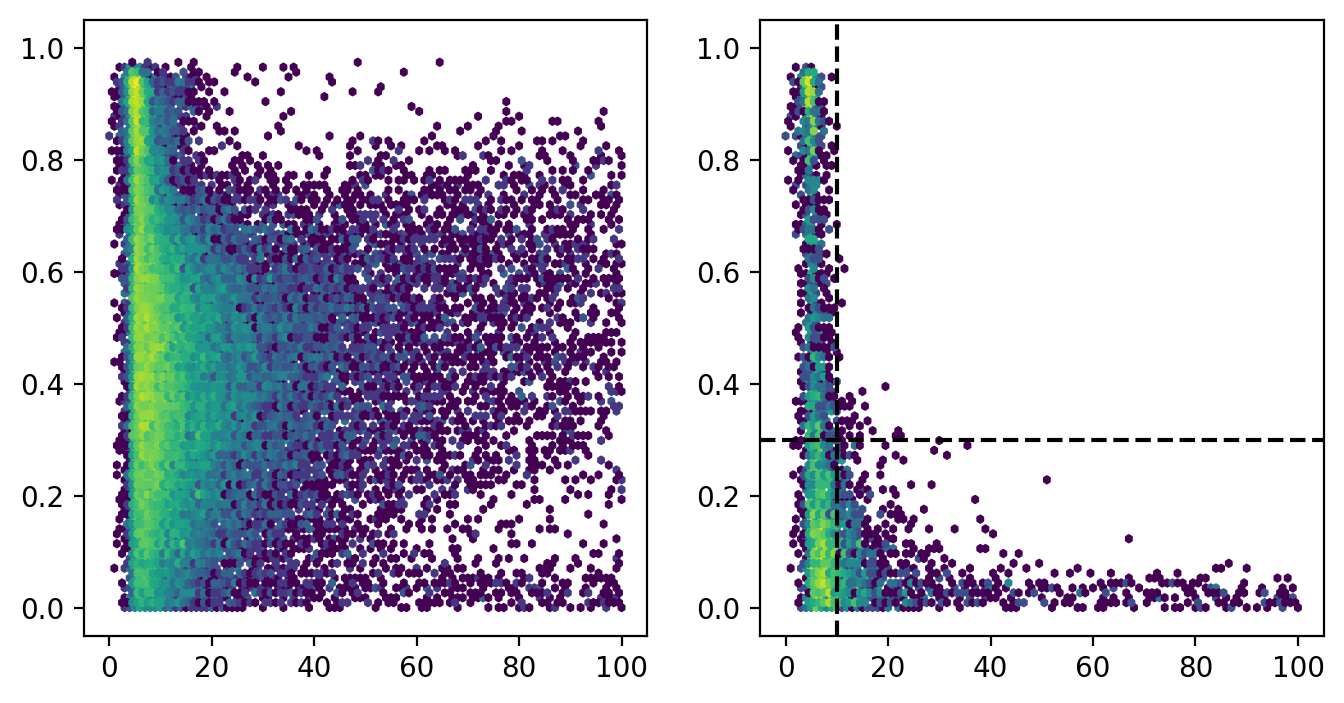

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

# near_table = table[table['sep'] < 0.5]
cmodel_snr = table['i_cModelFlux']/table['i_cModelFluxErr']
ax[0].hexbin(cmodel_snr, table['res'], extent=(0, 100, 0, 1), bins='log')

star_filt = np.logical_or.reduce((table['i_extendedness'] == 0,
                                  table['refExtendedness'] == 0))
ax[1].hexbin(cmodel_snr[star_filt], table['res'][star_filt], extent=(0, 100, 0, 1), bins='log')
ax[1].axvline(10, ls='--', color='k')
ax[1].axhline(0.3, ls='--', color='k')
# ax.plot(cmodel_snr, near_table['res'], '.')
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 1)

In [48]:
wl_filt = get_wlfilt(table, mag_lim=23.76, bright_lim=18, SNR=0, apply_extend=True)
wl_table = table[wl_filt]

After WL cuts: 16127


Text(0.5, 1.0, 'Distribution of Galaxy Magnitudes')

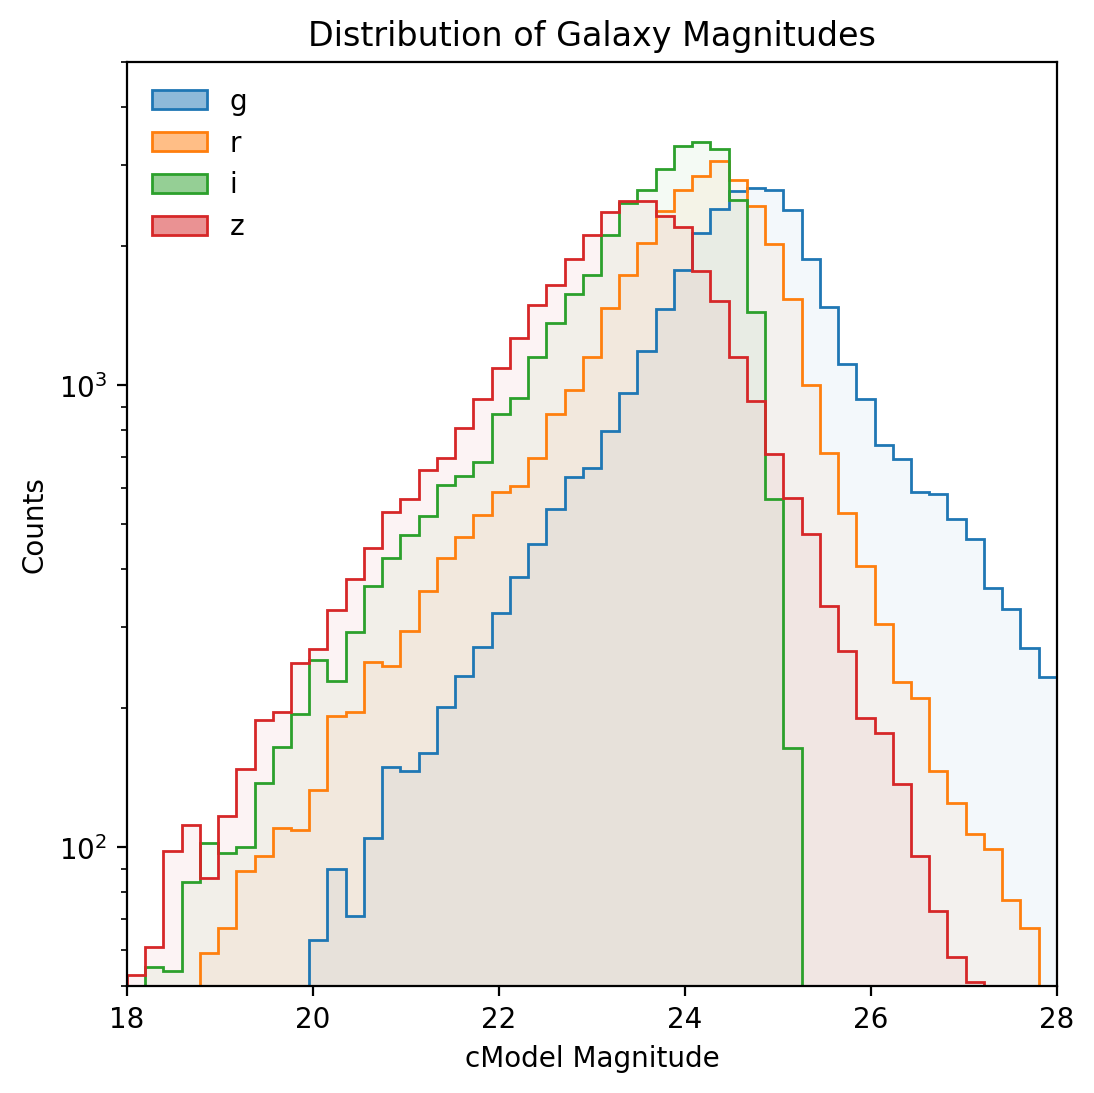

In [180]:
fig, ax = plt.subplots(ncols=1, figsize=(6,6))

near_table = table[np.logical_and(table['sep'] < 0.5, table['refExtendedness']==1)]
cmap = cm.tab10
band_list = 'griz'
legend_elems = [Patch(facecolor=cmap(i, 0.5), edgecolor=cmap(i), label=band) for i,band in enumerate(band_list)]
# band_lims = [25.3, 24.9, 24.5, 24.0]
# band_lims = [24.9, 24.4, 24.2, 23.5]
for i in range(4):
    band = band_list[i]
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), bins=51, histtype='step', label=band);
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), color=cmap(i), bins=51, histtype='stepfilled', alpha=0.05);
    # ax.axvline(band_lims[i], ls='-', alpha=1, color=cmap(i), label=f'{band} = {band_lims[i]}')
ax.set_xlim(18, 28)
ax.set_ylim(5e1, 5e3)
ax.set_xlabel('cModel Magnitude')
ax.semilogy()
# ax.legend(frameon=False, loc='upper left')
ax.legend(frameon=False, handles=legend_elems, loc='upper left')
ax.set_ylabel("Counts", x=0.05)
ax.set_title("Distribution of Galaxy Magnitudes")
# plt.savefig('./figs/galaxy_dist.png', dpi=450)

In [181]:
# fig, ax = plt.subplots(ncols=1, figsize=(6,6))

# near_table = table[np.logical_and(table['sep'] < 0.5]
# cmap = cm.tab10
# band_list = 'griz'
# legend_elems = [Patch(facecolor=cmap(i, 0.5), edgecolor=cmap(i), label=band) for i,band in enumerate(band_list)]
# # band_lims = [25.3, 24.9, 24.5, 24.0]
# # band_lims = [24.9, 24.4, 24.2, 23.5]
# for i in range(4):
#     band = band_list[i]
#     ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), bins=51, histtype='step', label=band);
#     ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), color=cmap(i), bins=51, histtype='stepfilled', alpha=0.05);
#     # ax.axvline(band_lims[i], ls='-', alpha=1, color=cmap(i), label=f'{band} = {band_lims[i]}')
# ax.set_xlim(18, 28)
# ax.set_ylim(5e1, 5e3)
# ax.set_xlabel('cModel Magnitude')
# ax.semilogy()
# # ax.legend(frameon=False, loc='upper left')
# ax.legend(frameon=False, handles=legend_elems, loc='upper left')
# ax.set_ylabel("Counts", x=0.05)
# ax.set_title("Distribution of Galaxy Magnitudes")
# # plt.savefig('./figs/galaxy_dist.png', dpi=450)

## Color Cut

### Red Sequence

We can identify the cluster members by plotting a color magnitude diagram 

476


Text(0.5, 0.01, 'cModel $i$-mag')

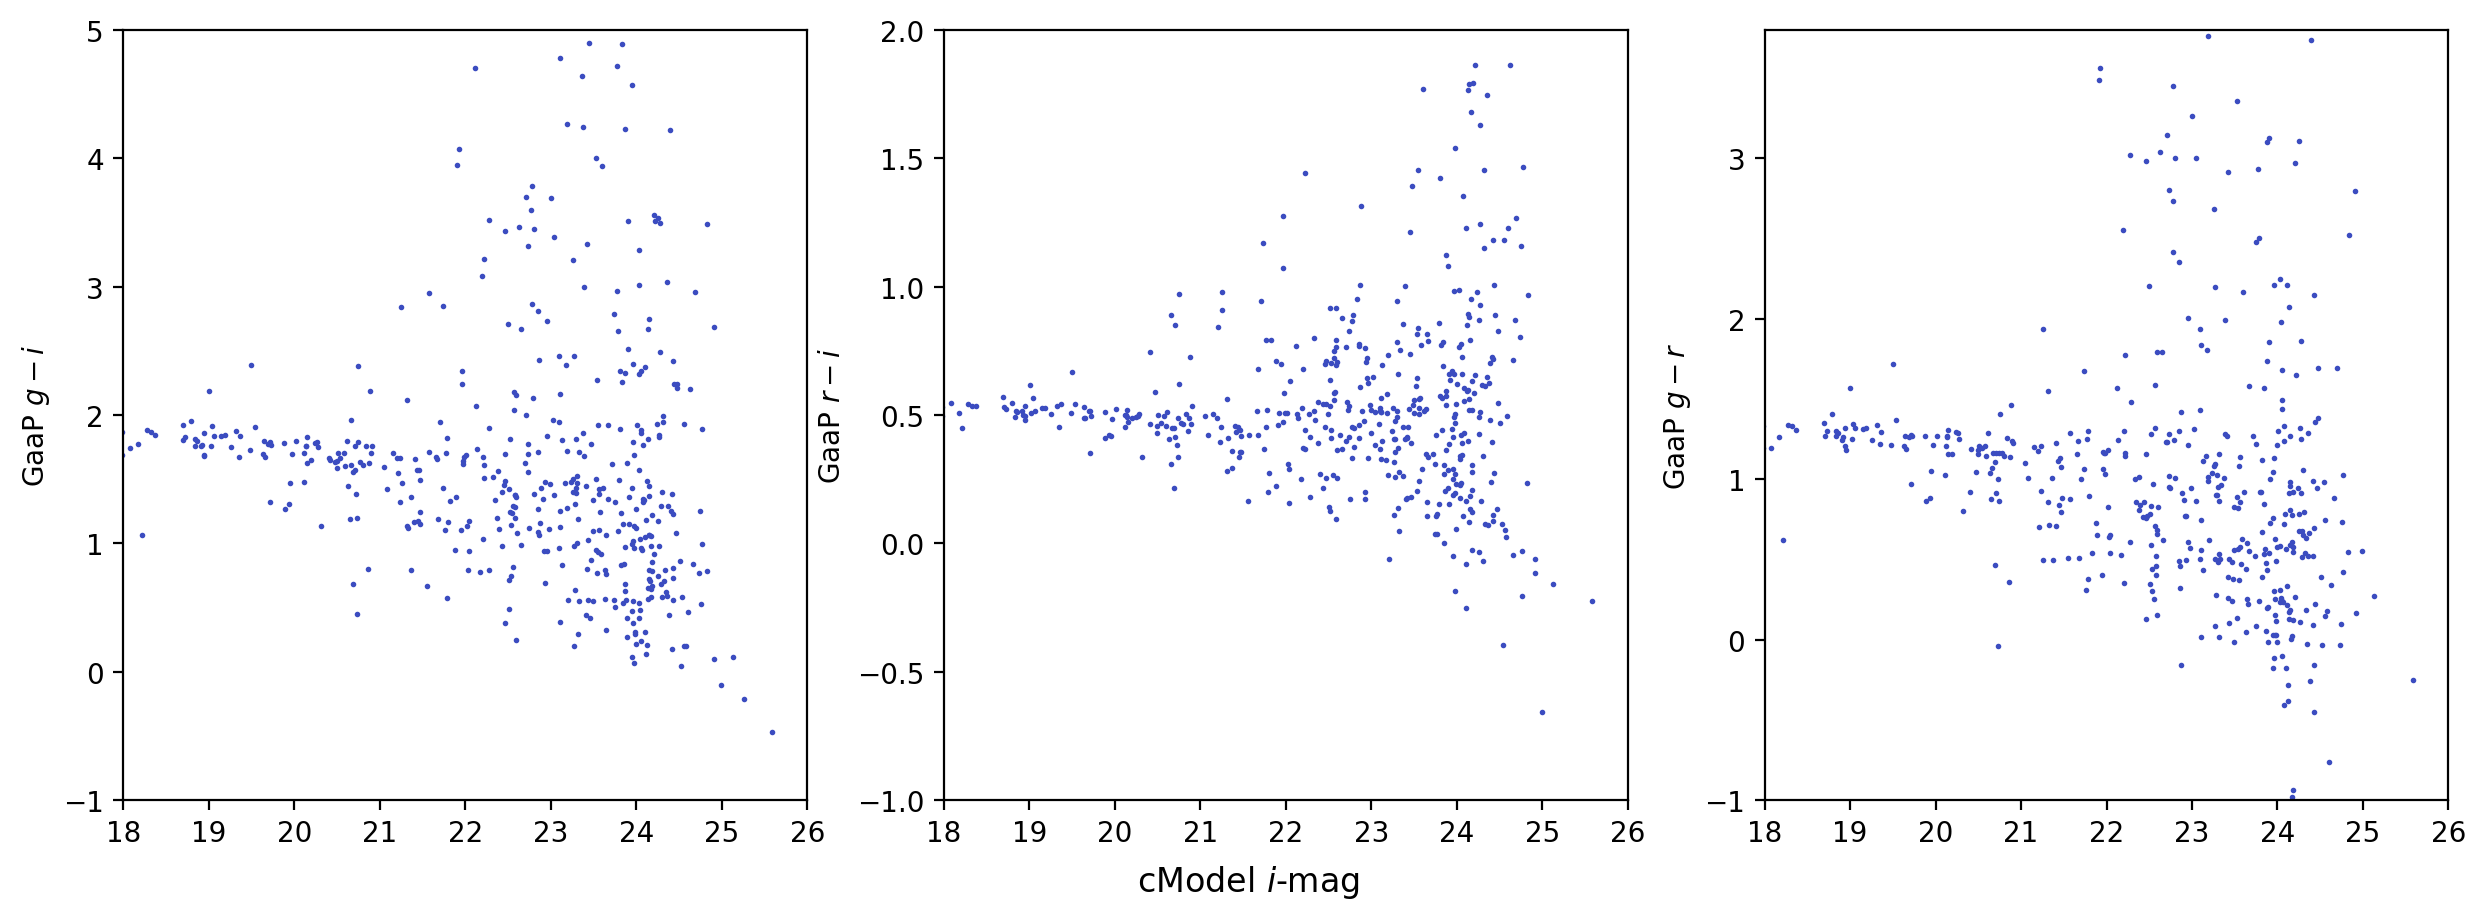

In [125]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5)) 

rs_table = table[np.logical_and(table['sep'] < 3/60, table['refExtendedness']==1)]
print(len(rs_table))

color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
cmap = cm.coolwarm
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=4, color=cmap(0))
    # ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], c=rs_table['sep'], marker='.', s=4)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

# ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0), alpha=0.2)
# ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0), alpha=0.2)

# ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0), alpha=0.2)
# ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0), alpha=0.2)

# ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0), alpha=0.2)
# ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0), alpha=0.2)

fig.supxlabel(r"cModel $i$-mag")

In [126]:
# table, table_plus, table_neg, rs_table_upper, rs_table_lower = apply_redsequence_noisy(table, sigma=1.5, mag_lim=23.76)
delta = 0.05
table = apply_redsequence_noisy(table, sigma=1, mag_lim=23.76, bright_lim=18, delta=delta)

/tmp/ipykernel_149/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:46: RuntimeWarning: invalid value encountered in log10
  gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:47: RuntimeWarning: invalid value encountere

145 180 146


Text(0.5, 0.01, 'cModel $i$-mag')

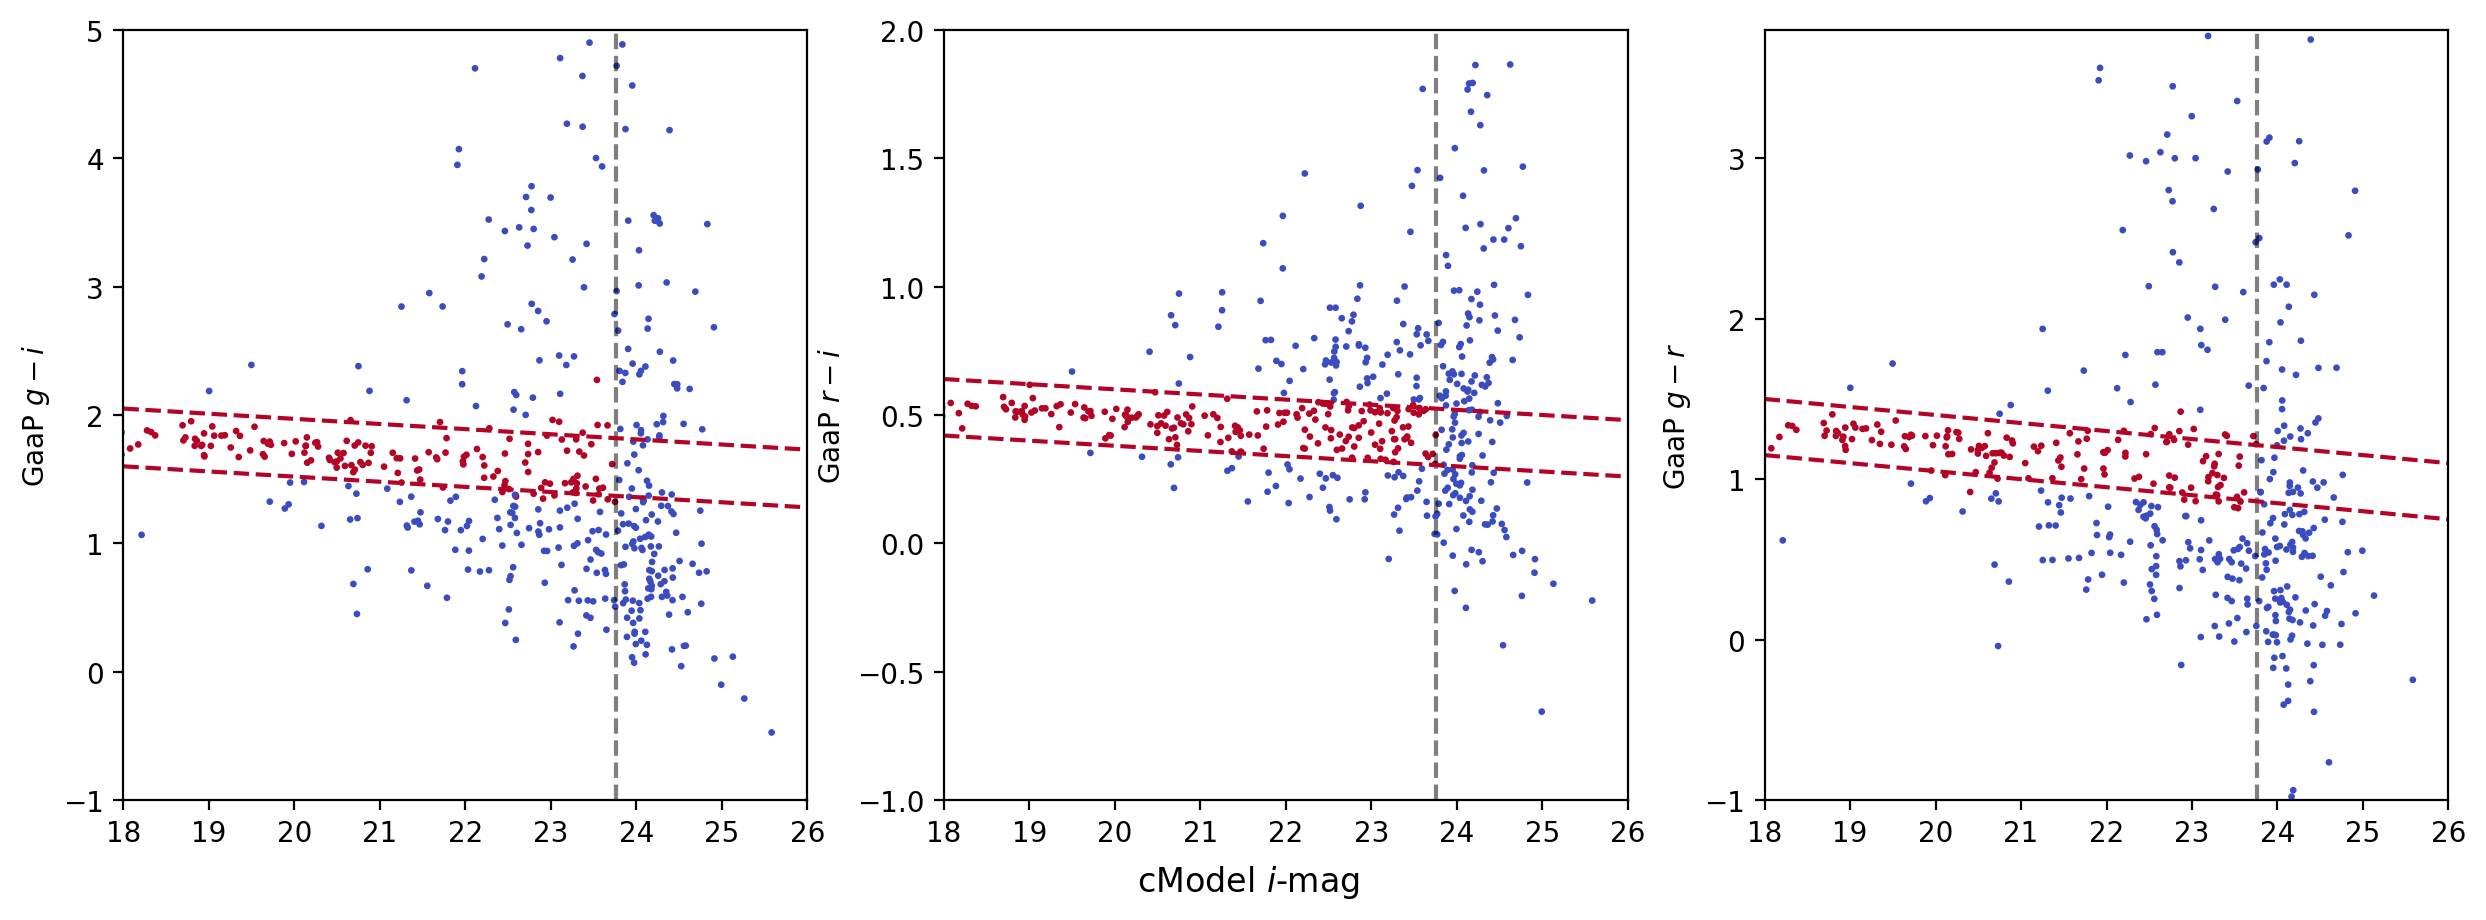

In [127]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 3/60, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    col_filt = rs_table[f'{col}_redseq']
    # col_filt = np.logical_or(redseq_err[i], rs_table[f'{col}_redseq'])
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=8, c=col_filt, cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)
    # ax[i].axvline(20, ls='--', color='k', alpha=0.5)
    ax[i].axvline(23.76, ls='--', color='k', alpha=0.5)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0))
ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0))

ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0))
ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0))

ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0))
ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0))

fig.supxlabel(r"cModel $i$-mag")

783 1203 854


Text(0.5, 0.05, 'cModel $i$-mag')

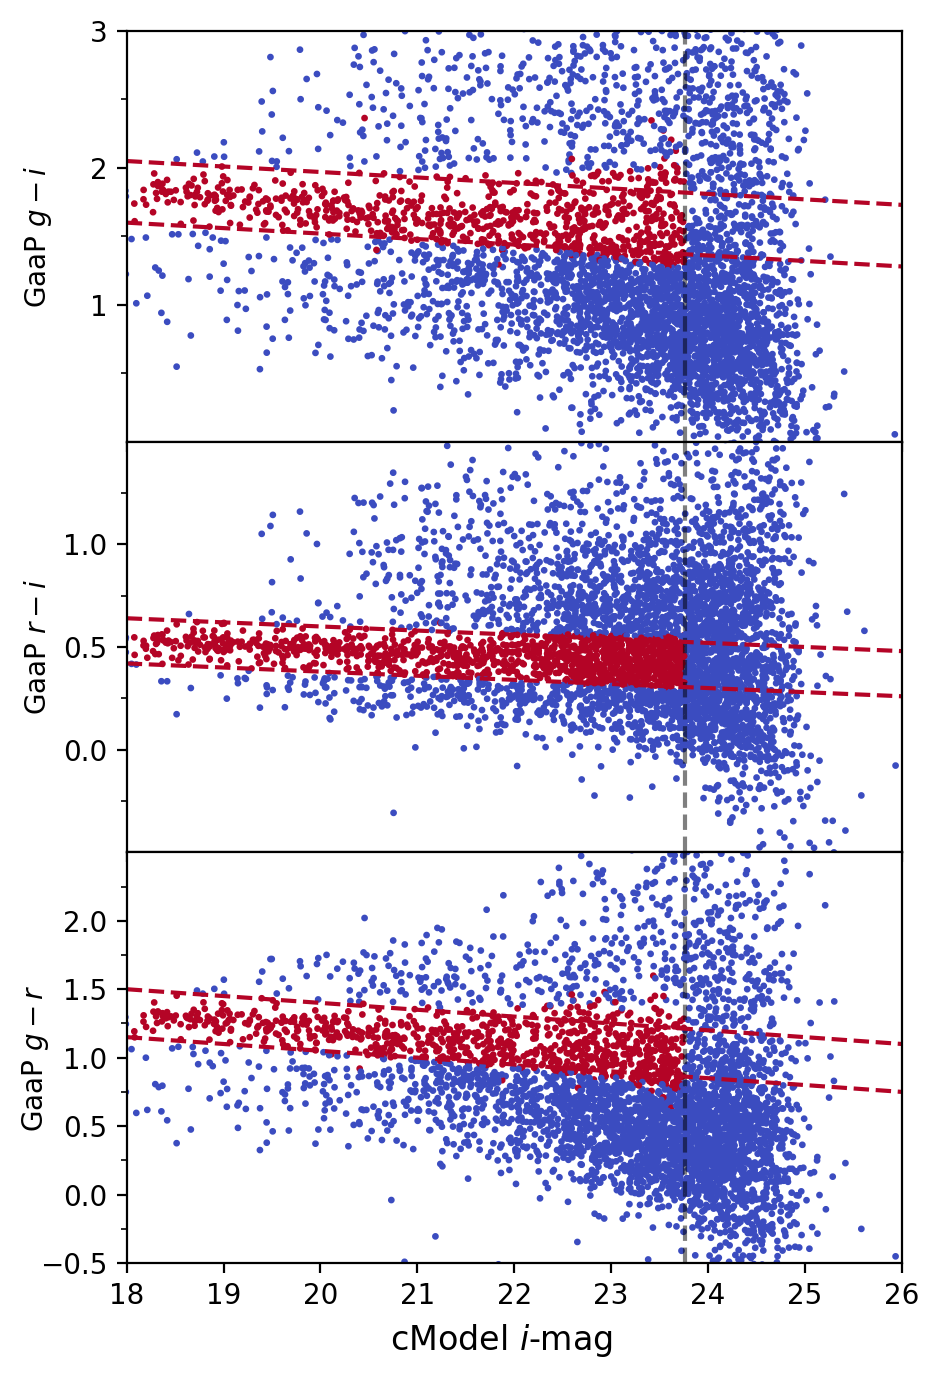

In [128]:
# fig, ax = plt.subplots(nrows=3, figsize=(5, 10), sharex=True)
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(nrows=3, hspace=0)
ax = gs.subplots(sharex=True)

rs_table = table[np.logical_and(table['sep'] < 10/60, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']

lpads = [13,4,-4]
for i in range(3):
    col = color_names[i]
    col_filt = rs_table[f'{col}_redseq']
    # col_filt = np.logical_or(redseq_err[i], rs_table[f'{col}_redseq'])
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=8, c=col_filt, cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}', labelpad=lpads[i])
    ax[i].set_xlim(18, 26)
    # ax[i].axvline(20, ls='--', color='k', alpha=0.5)
    ax[i].axvline(23.76, ls='--', color='k', alpha=0.5)

ax[0].set_ylim(0, 3)
ax[1].set_ylim(-0.5, 1.5)
ax[2].set_ylim(-0.5, 2.5)

ax[0].set_yticks([1.0,2.0,3.0], minor=False)
ax[0].set_yticks([0.5, 1.5, 2.5], minor=True)
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_yticks([-0.25, 0.25, 0.75, 1.25], minor=True)
ax[2].set_yticks([-0.5, 0, 0.5, 1, 1.5, 2])
ax[2].set_yticks([-0.25, 0.25, 0.75, 1.25, 1.75, 2.25], minor=True)

ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0))
ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0))

ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0))
ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0))

ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0))
ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0))

fig.supxlabel(r"cModel $i$-mag", y=0.05)

394 553 414


Text(0.5, 0.05, 'cModel $i$-mag')

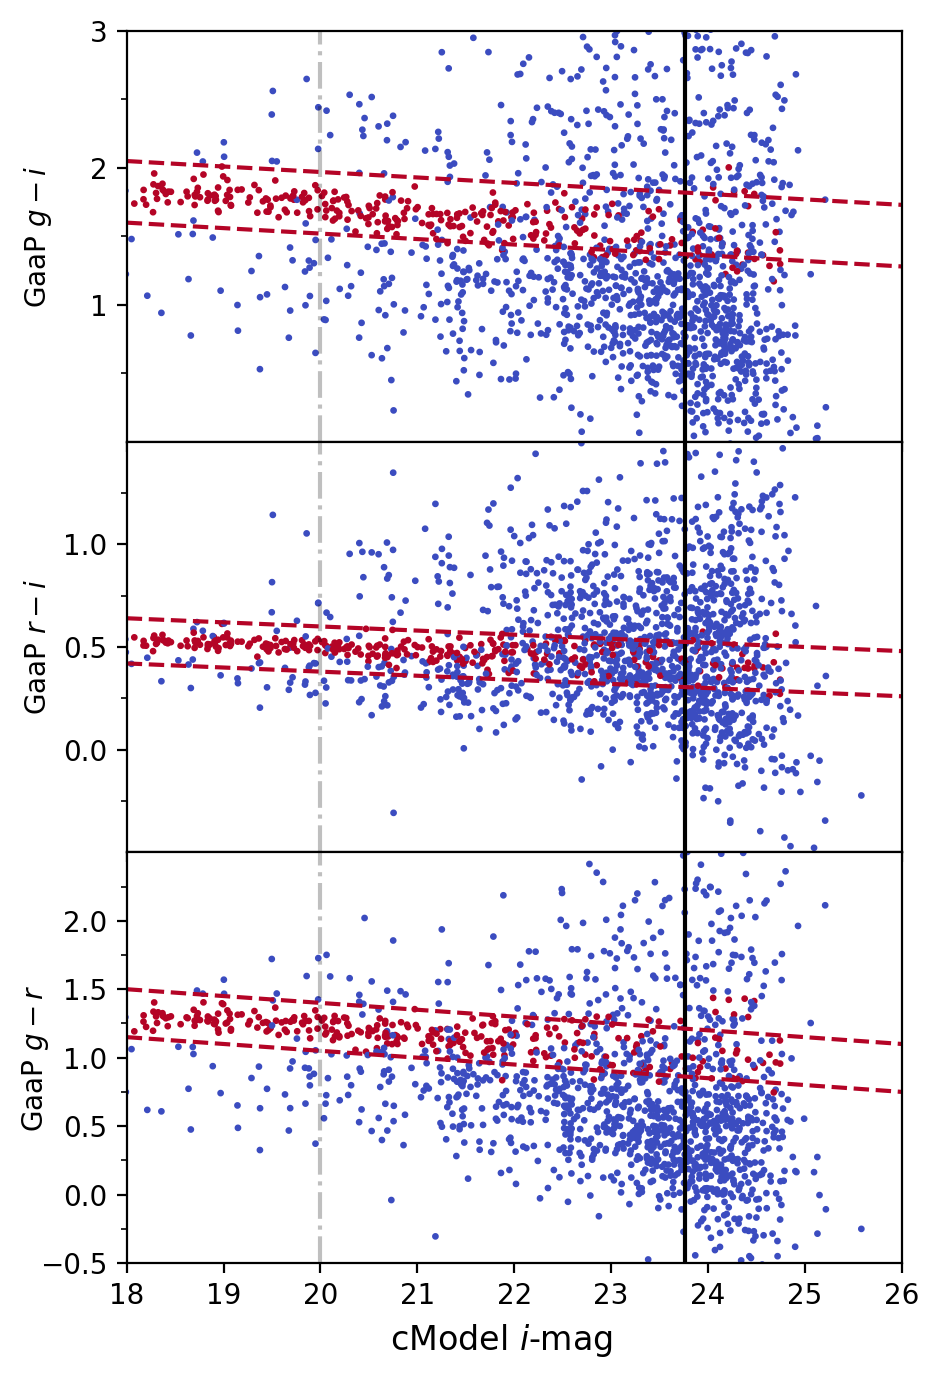

In [135]:
# fig, ax = plt.subplots(nrows=3, figsize=(5, 10), sharex=True)
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(nrows=3, hspace=0)
ax = gs.subplots(sharex=True)

rs_table = table[np.logical_and(table['sep'] < 6/60, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']

lpads = [13,4,-4]
for i in range(3):
    col = color_names[i]
    col_filt = rs_table[f'all_redseq']
    # col_filt = np.logical_or(redseq_err[i], rs_table[f'{col}_redseq'])
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=8, c=col_filt, cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}', labelpad=lpads[i])
    ax[i].set_xlim(18, 26)
    ax[i].axvline(20, ls='-.', color='k', alpha=0.25)
    ax[i].axvline(23.76, ls='-', color='k')

ax[0].set_ylim(0, 3)
ax[1].set_ylim(-0.5, 1.5)
ax[2].set_ylim(-0.5, 2.5)

ax[0].set_yticks([1.0,2.0,3.0], minor=False)
ax[0].set_yticks([0.5, 1.5, 2.5], minor=True)
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_yticks([-0.25, 0.25, 0.75, 1.25], minor=True)
ax[2].set_yticks([-0.5, 0, 0.5, 1, 1.5, 2])
ax[2].set_yticks([-0.25, 0.25, 0.75, 1.25, 1.75, 2.25], minor=True)

ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0))
ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0))

ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0))
ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0))

ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0))
ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0))

fig.supxlabel(r"cModel $i$-mag", y=0.05)

145 180 146


Text(0.5, 0.01, 'cModel $i$-mag')

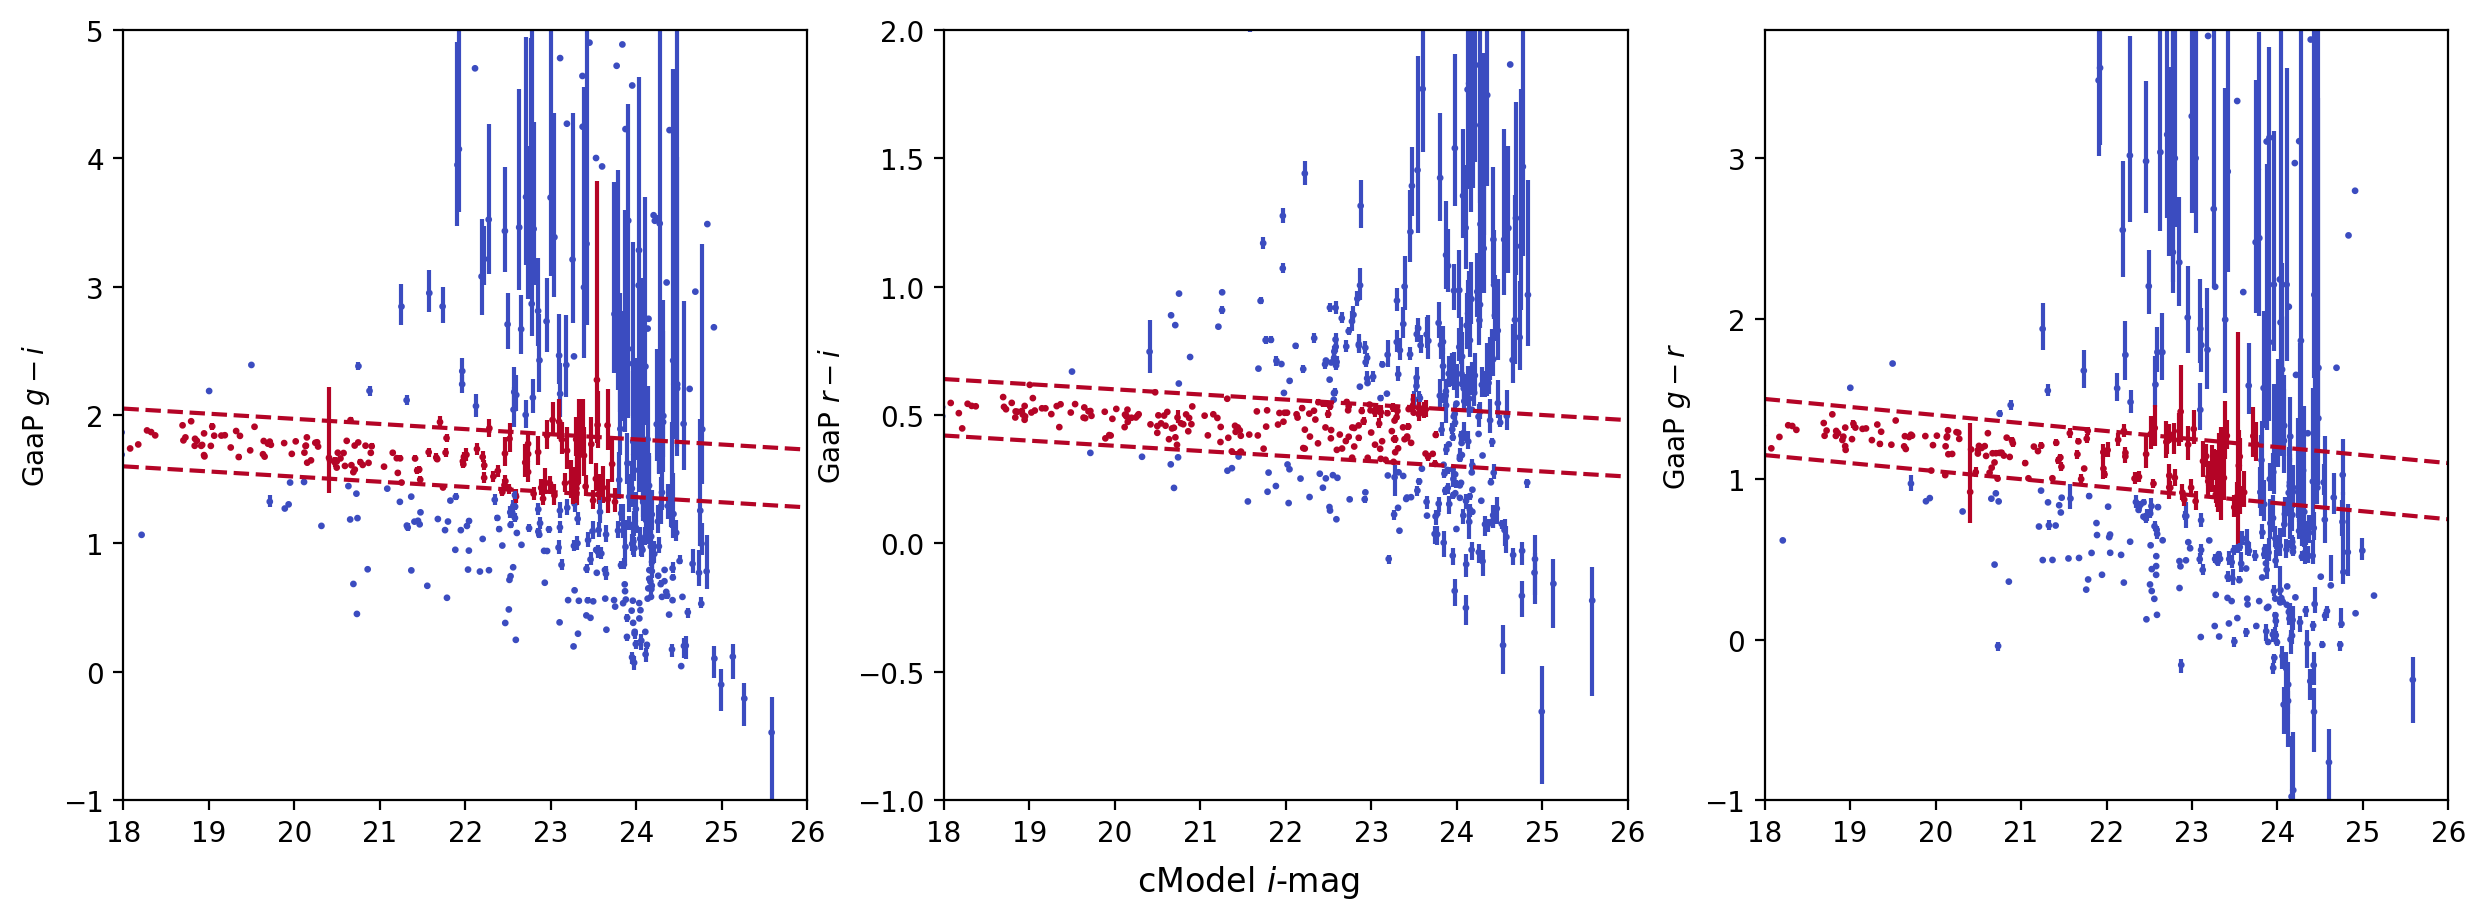

In [136]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 3/60, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    col_filt = rs_table[f'{col}_redseq']
    # col_filt = np.logical_or(redseq_err[i], rs_table[f'{col}_redseq'])
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=8, c=col_filt, cmap=cmap)
    ax[i].vlines(rs_table['i_cModel_mag'],rs_table[col+'_neg'],  rs_table[col+'_plus'], color=cmap((col_filt).astype(float)))
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0))
ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0))

ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0))
ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0))

ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0))
ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0))

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $i$-mag")

292


Text(0.5, 0.01, 'cModel $i$-mag')

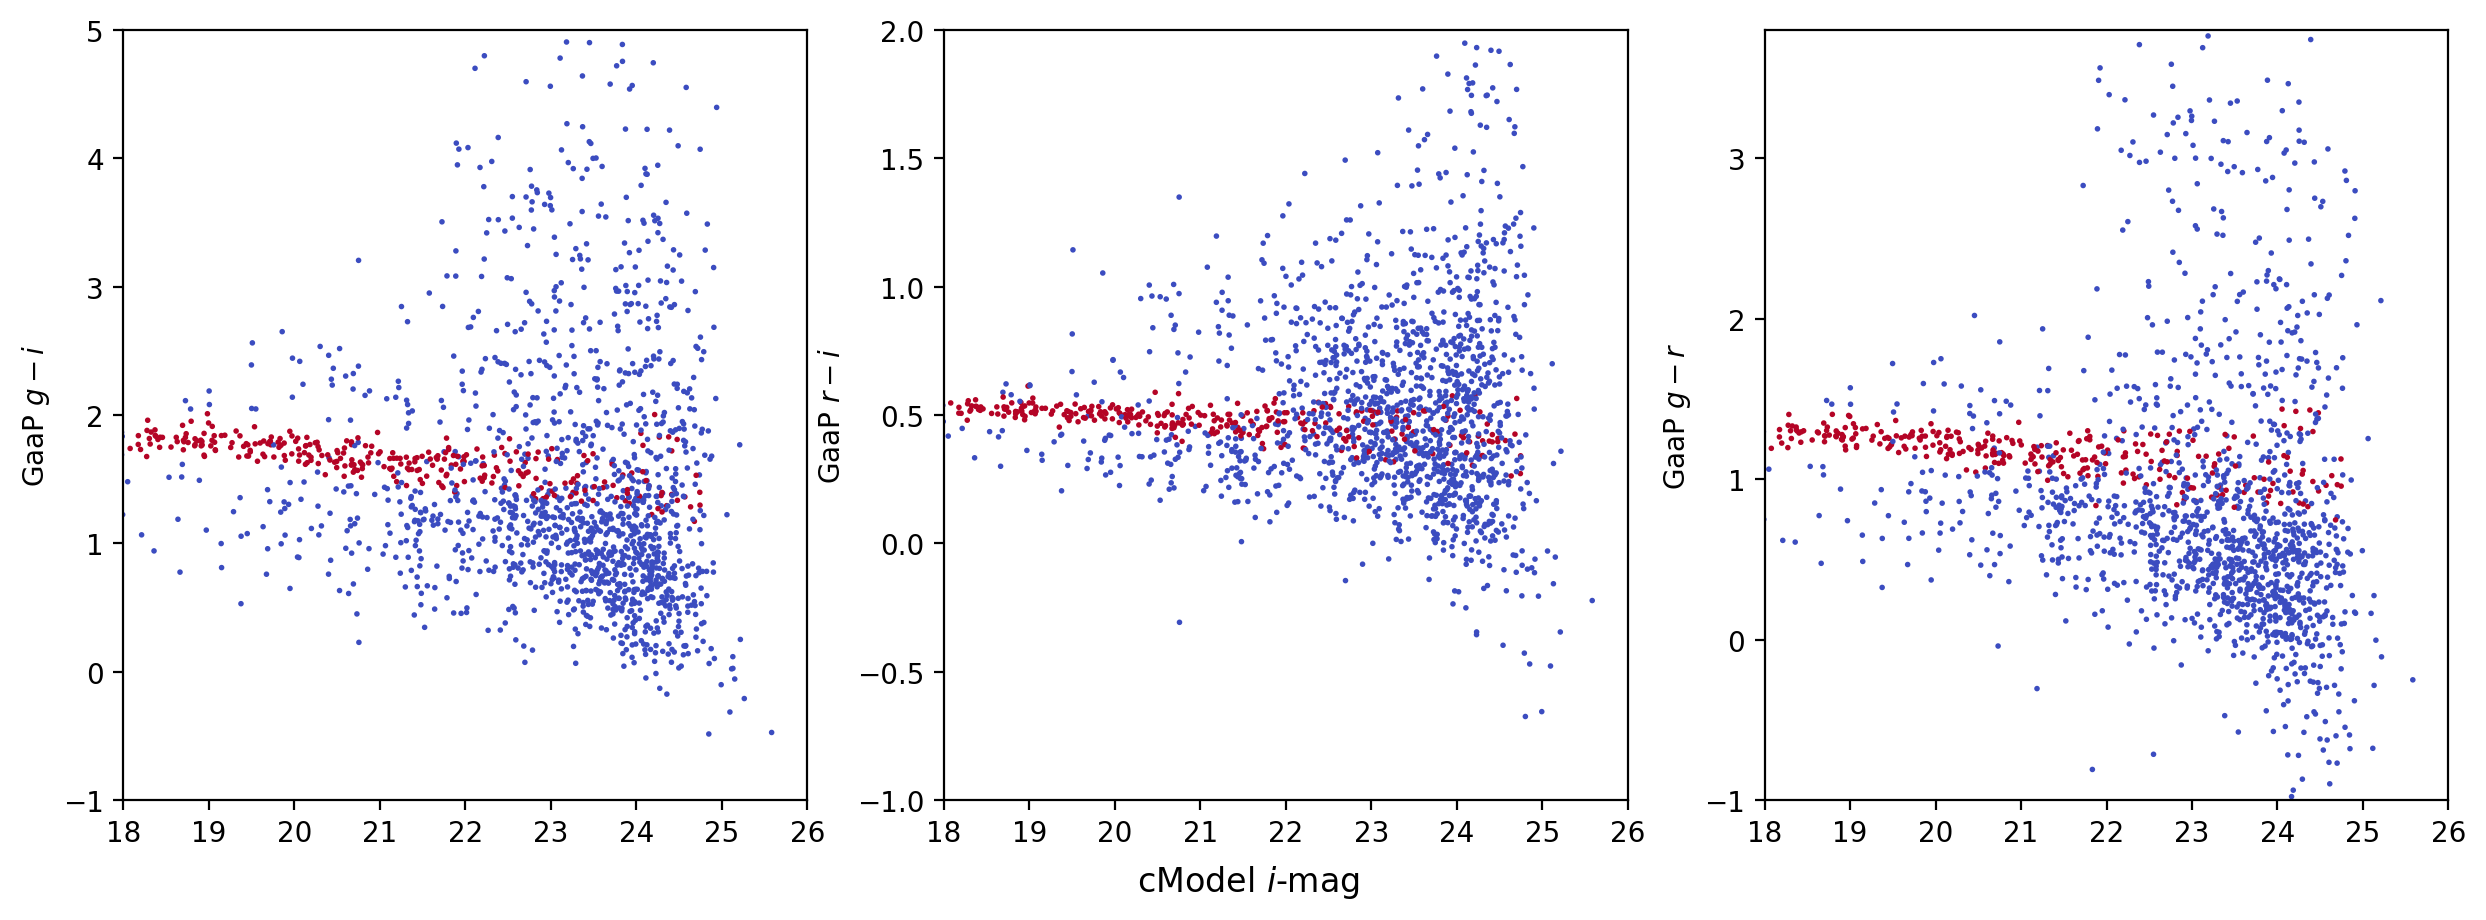

In [137]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 0.1, table['refExtendedness']==1)]
print(np.sum(rs_table['all_redseq']))
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=4, c=rs_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $i$-mag")

In [138]:
wl_filt = get_wlfilt(table, mag_lim=23.76, bright_lim=20, SNR=0, apply_extend=True)
table = table[wl_filt]

After WL cuts: 15100


In [139]:
Nobj = len(table)
Nrs = np.sum(table['all_redseq'])
print(Nrs, Nobj-Nrs)

1114 13986


### Write Tables

In [140]:
# Apply cuts
cut_types = ['all', 'ri', 'gr', 'gi']
wl_filt = get_wlfilt(table, mag_lim=23.76)
for ct in cut_types:
    filt = np.logical_and(wl_filt,  ~(table[f'{ct}_redseq']))
    print(f"After {ct} cuts: {np.sum(filt)}")
    source_table = table[filt]
    source_table.meta = {}
    source_table.write(f'{outdir}/abell360_POSTCUTS_{ct}noisy_masked_DP1.fits', format="fits", overwrite=True)

After WL cuts: 14699
After all cuts: 13598
After ri cuts: 9877
After gr cuts: 11487
After gi cuts: 11812


## Photo-z Cuts

Another way for us to obtain the source sample is by removing objects that have $z \leq 0.22$ which we can do using photometric redshift estimates.
Here we load in both the point estimates and the $P(z)$ distributions for each object.

In [213]:
# # Get point estimates for the entire field (169034 objects)
pz_ests = pd.read_parquet(pz_sv38_point)
pz_ests = Table.from_pandas(pz_ests)

In [214]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [215]:
# We could load this in via butler we did save this earlier :)
# This is the cleaned catalog that removed entries if any of the measurement algorithms failed.
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_new.fits', format="fits")
# dp1_catalog, _ = load_pz_photomdata(ddir='/global/cfs/cdirs/lsst/groups/PZ/DP1/data/dp1_v29.0.0/', suffix='parquet')
dp1_catalog, _ = load_pz_photomdata(clean_fn=preclean_filt)
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [216]:
pz_table = join(dp1_catalog, pz_ests, keys='objectId')

In [217]:
# The P(z) PDFs are stored in a qp file which we can access via the get_pdfs function
# This contains the PDFs for all objects in the field which would be too much data to
# load in this notebook. We only want the PDFs for the objects that have passed our
# basic quality cuts.

clean_pz_ids = pz_table['objectId']
all_pz_ids = pz_ests['objectId']
big_pz_filt = np.isin(all_pz_ids, clean_pz_ids)
# big_pz_filt = [k in clean_pz_ids for k in pz_ests['objectId']]


In [218]:
xs = np.linspace(0, 3, 301)

### Entire Sample $N(z)$

In [147]:
plot_algs = ['bpz', 'dnf', 'fzboost', 'knn']
quality_pdfs = []

for alg in plot_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt, pz_dir=pz_sv38_pdf_dir)
    c = gc.collect()
    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 29364
On dnf we have 40734
On fzboost we have 27654
On knn we have 33273


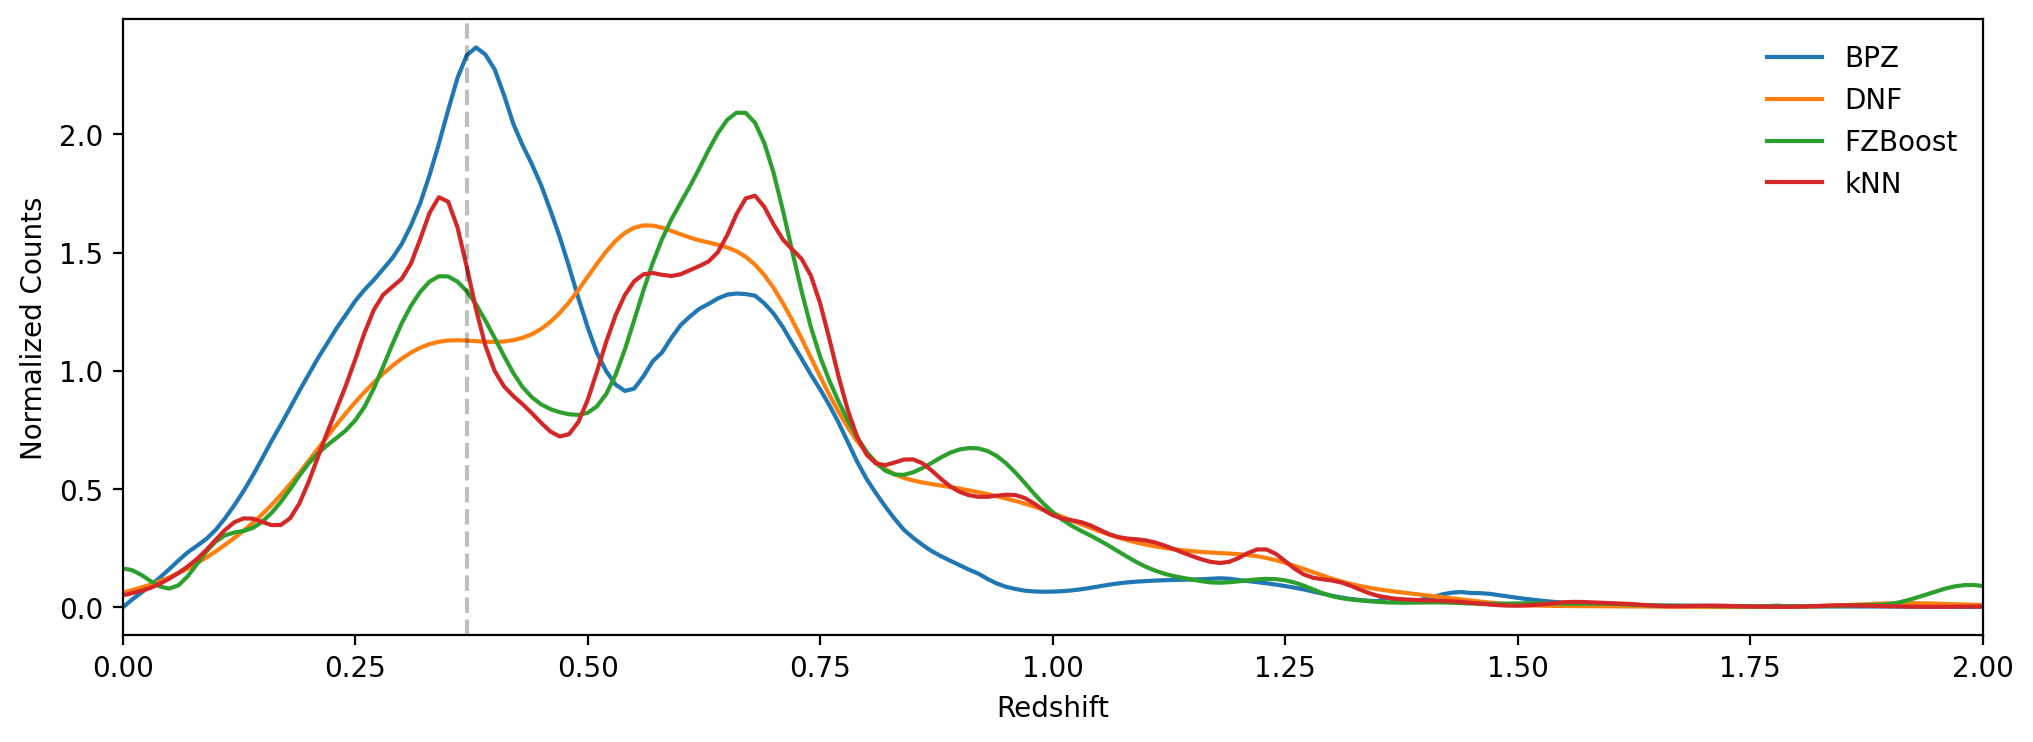

In [149]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'DNF', 'FZBoost', 'kNN']
for i, alg in enumerate(plot_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

### Write Tables

Save the photo-z subsets

In [221]:
pz_mask = get_masks(pz_table)
pz_table = pz_table[pz_mask]

In [222]:
pz_wlfilt = get_wlfilt(pz_table, apply_sep=True, mag_lim=23.76)
pz_wltable = pz_table[pz_wlfilt]

After WL cuts: 12734


In [223]:
# Apply cuts
# pz_algs = ['knn', 'tpz', 'cmnn', 'gpz', 'bpz', 'dnf', 'fzboost', 'lephare']
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']
pz_cutoff = 0.37
# pz_cutoff2 = 0.65

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'

    filt = pz_wltable[f'{alg}_z_{central}'] > pz_cutoff
    # if not (alg=='gpz'):
    #     filt &= pz_table[f'{alg}_diff'] < 0.25

    print(f"After cuts: {np.sum(filt)}")
    source_table = pz_wltable[filt]
    source_table.write(f'{outdir}/abell360_POSTCUTS_{alg}0.37nq_masked_DP1.fits', format="fits", overwrite=True)

After cuts: 10048
After cuts: 11293
After cuts: 11853
After cuts: 10386
After cuts: 12083
After cuts: 11002
After cuts: 10101
After cuts: 9706


Save subsets for the shear-ratio plot

In [90]:
# Apply cuts
pz_algs = ['knn', 'tpz', 'cmnn', 'gpz', 'bpz', 'dnf', 'fzboost', 'lephare']
pz_cutoff1 = 0.37
pz_cutoff2 = 0.65

pz_wlfilt = get_wlfilt(pz_table)

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'

    filt = np.logical_and(pz_wlfilt, pz_table[f'{alg}_z_{central}'] > pz_cutoff)
    filt &= pz_table[f'{alg}_z_{central}'] < pz_cutoff2 # Change this from < to > when doing bin1 or bin2
    if not (alg=='gpz'):
        filt &= pz_table[f'{alg}_diff'] < 0.25

    print(f"After cuts: {np.sum(filt)}")
    source_table = pz_table[filt]
    source_table.write(f'{outdir}/shear-ratio_{alg}bin1_DP1.fits', format="fits", overwrite=True)

After WL cuts: 17828
After cuts: 2716
After cuts: 3218
After cuts: 489
After cuts: 4028
After cuts: 3471
After cuts: 4236
After cuts: 2858
After cuts: 1370


In [91]:
# quality_pdfs = np.array(quality_pdfs)

# quality_pdfs.shape

# np.save('cluster_data/technote/nz/colorcuts_nz_noquality.npy', quality_pdfs)

## Color-Color Cuts

In [224]:
# match_cc = Table.read('/home/a/adari/u/clusters/data/match_desi.fits')
# bands = list('griz')
# for b in bands:
#     match_cc.rename_column(f'{b}_cModelMag', f'{b}_cModel_mag')
#     match_cc.rename_column(f'{b}_gaap1p0Mag', f'{b}_gaap_mag')

# match_cc = Table.read('cluster_data/desi_sv38_matches_big.fits')

# # match_cc['gi'] = match_cc['g_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# # match_cc['ri'] = match_cc['r_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# # match_cc['gr'] = match_cc['g_gaap1p0Mag'] - match_cc['r_gaap1p0Mag']

# match_cc = apply_redsequence(match_cc, mag_lim=23.76)

# # # clean_filt = preclean_filt(preclean_table)
# # # print(len(preclean_table) - np.sum(clean_filt))
# # # clean_table = preclean_table[clean_filt]

# # # clean_table = apply_redsequence(clean_table, mag_lim=28)

# # # cmap = cubehelix_colormap(
# # #    start=0,
# # #    rot=-0.1,
# # #    gamma=1,
# # #    hue=5,
# # #    light=0.85,
# # #    dark=0.15,
# # #    name="test",
# # # )
# # # cmap_r = cmap.reversed()

# # # cmap_r

# # # imag_cut = wl_table[wl_table['i_cModel_mag'] < 23.76]
# # # imag_cut = apply_redsequence(imag_cut)

# # # fig, ax = plt.subplots(1, figsize=(6,6))

# # # # cmap = cm.coolwarm
# # # ax.hexbin(imag_cut['gr'] ,imag_cut['ri'])
# # # ax.scatter(match_cc['gr'], match_cc['ri'], s=8, c=match_cc['desi_z'], cmap=cmap_r)


# # # ax.set_xlim(-0.5, 2.5)
# # # ax.set_ylim(-0.5, 1.5)
# # # ax.set_xlabel("g-r")
# # # ax.set_ylabel("r-i")

# # fig, ax = plt.subplots(1, figsize=(6,6))

# # # cmap = cm.coolwarm
# # ax.hexbin(imag_cut['gi'] ,imag_cut['ri'])
# # ax.scatter(match_cc['gi'], match_cc['ri'], s=8, c=match_cc['desi_z'], cmap=cmap_r)


# # ax.set_xlim(-0.5, 2.5)
# # ax.set_ylim(-0.5, 1.5)
# # ax.set_xlabel("g-i")
# # ax.set_ylabel("r-i")

## SV 38-7 $N(z)$

In [232]:
# Get point estimates for the entire field (169034 objects)
pz_ests = pd.read_parquet(pz_sv38_point)
pz_ests = Table.from_pandas(pz_ests)
pz_diffs(pz_ests, pz_algos)

### Color-cuts $N(z)$

Can't read in the previous files since there might be some mismatch between the objectIds between the Butler DP1 and the statically written DP1 used in photo-zs.

In [509]:
# Load in PZ DP1 photometry and add the point estimates
# load_pz_photomdata applies the preclean_filt
dp1_catalog, _ = load_pz_photomdata(clean_fn=preclean_filt)
pz_table = join(pz_ests, dp1_catalog, keys='objectId')

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [510]:
pz_mask = get_masks(pz_table)
pz_table = pz_table[pz_mask]

In [511]:
# Apply the WL Cuts
wl_pzfilt = get_wlfilt(pz_table, mag_lim=23.76, bright_lim=20)
wl_pztable = pz_table[wl_pzfilt]

After WL cuts: 12734


In [512]:
# Write the red-sequence
wl_pztable = apply_redsequence_noisy(wl_pztable, mag_lim=23.76, sigma=1)

/tmp/ipykernel_149/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:46: RuntimeWarning: invalid value encountered in log10
  gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:48: RuntimeWarning: invalid value encountere

In [513]:
# True for objects that SHOULD be in the weak lensing catalog
wl_pz_ids = wl_pztable['objectId']
all_pz_ids = pz_ests['objectId']
# wl_pz_filt = np.array([k in wl_pz_ids for k in pz_ests['objectId']])
wl_pz_filt = np.isin(all_pz_ids, wl_pz_ids)

In [515]:
### pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
cc_cut_types = ['all', 'gi', 'ri', 'gr']
# cc_cut_types = ['all']
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']

for cc in cc_cut_types[:1]:
    wl_pdfs = []
    for alg in pz_algs:
        central = 'median' if alg=='knn' else 'mean'
        cc_filt = np.isin(all_pz_ids, wl_pztable['objectId'][~wl_pztable[f'{cc}_redseq']])
        new_filt = np.logical_and(wl_pz_filt, cc_filt)
        print(f"On {alg} we have {np.sum(new_filt)}")
        pdf, _, xs = get_pdfs(alg, new_filt, pz_dir = pz_sv38_pdf_dir)
        wl_pdfs.append(pdf)
    wl_pdfs = np.array(wl_pdfs)
    # np.save(f'cluster_data/sv38_nz_{cc}noisy.npy', wl_pdfs)

In [516]:
wl_pdfs = np.load('cluster_data/sv38_nz_allnoisy.npy')

Text(0.5, 1.0, 'SV_38_7 All Colors Red Sequence $N(z)$')

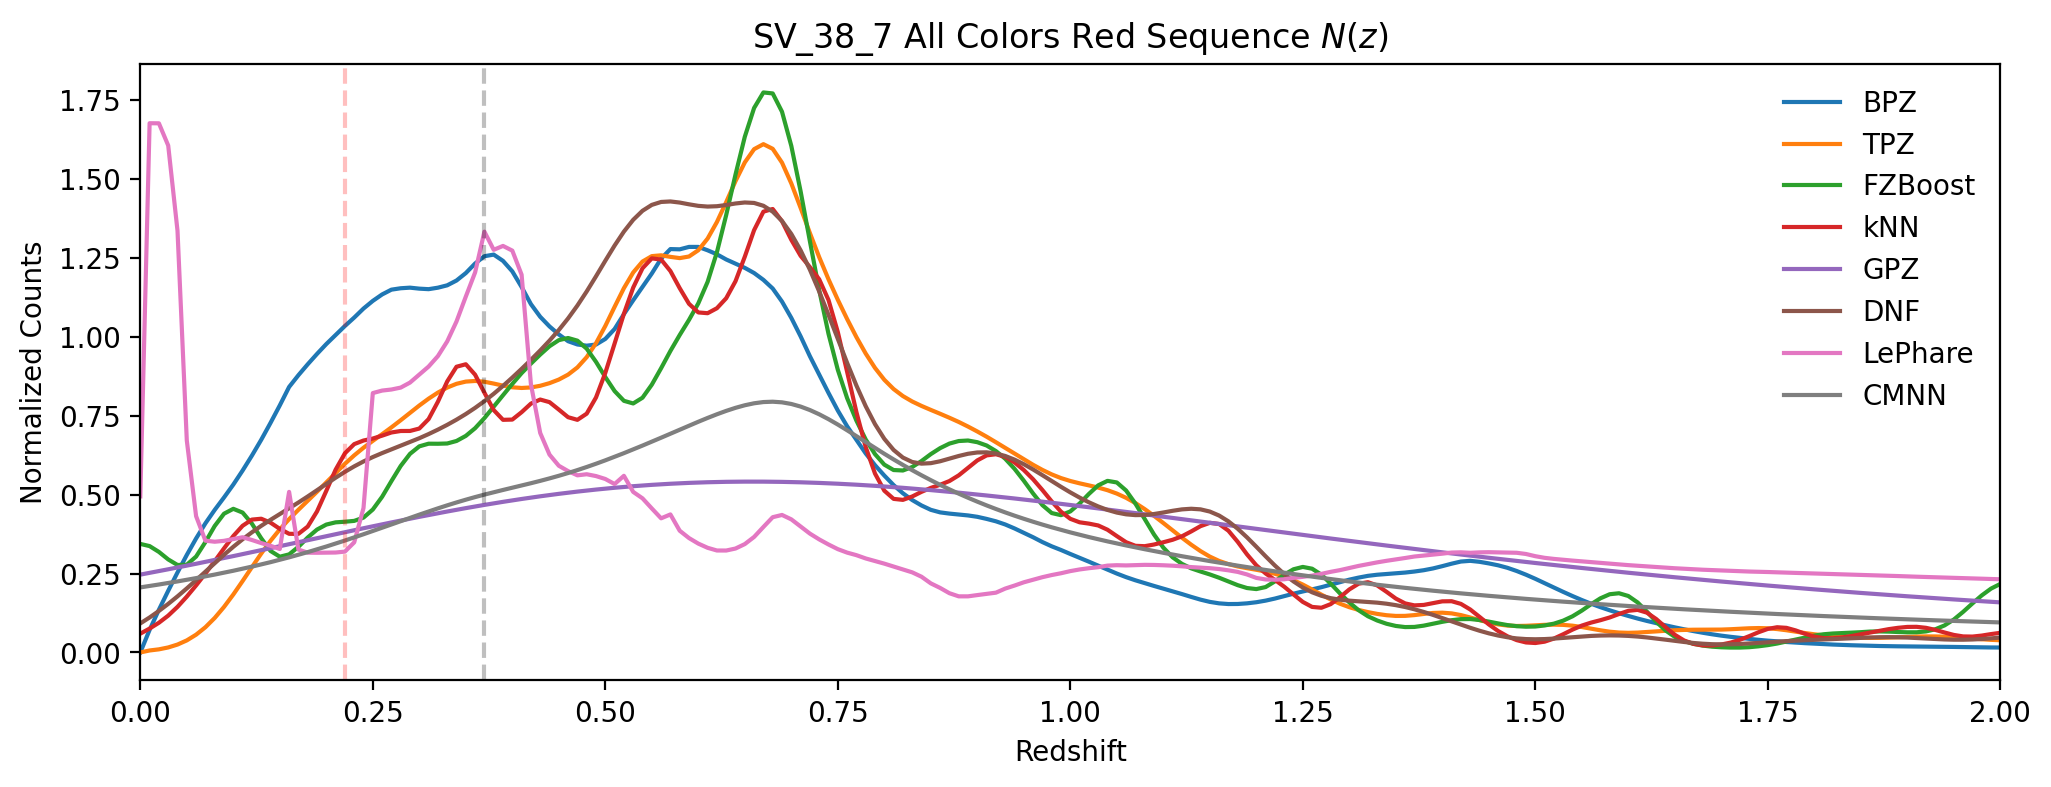

In [235]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, wl_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
plt.title("SV_38_7 All Colors Red Sequence $N(z)$")
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

### Photo-z Cut $N(z)$

In [236]:
# pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']
# pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']


pz_cutoff = 0.22+0.15
wl_pdfs = []

for alg in pz_algs:
    # central = 'median' if alg=='knn' else 'mean'
    # new_filt = np.logical_and.reduce((wl_pz_filt, pz_ests[f'{alg}_z_{central}'] > pz_cutoff,
    #                                   pz_ests[f'{alg}_diff'] < 0.25))
    # new_filt = np.logical_and(wl_pz_filt, pz_ests[f'{alg}_z_{central}'] > pz_cutoff)
    source_table = Table.read(f'{outdir}/abell360_POSTCUTS_{alg}0.37nq_masked_DP1.fits')
    new_filt = np.isin(pz_ests['objectId'], source_table['objectId'])
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt, pz_dir = pz_sv38_pdf_dir)
    wl_pdfs.append(pdf)

wl_pdfs = np.array(wl_pdfs)
np.save('cluster_data/sv38_nz_HSMnq_masked.npy', wl_pdfs)

On bpz we have 10048
On tpz we have 11293
On fzboost we have 11853
On knn we have 10386
On gpz we have 12083
On dnf we have 11002
On lephare we have 10101
On cmnn we have 9706


In [237]:
# wl_pdfs = np.load('cluster_data/sv38_nz_HSMnq_masked.npy')

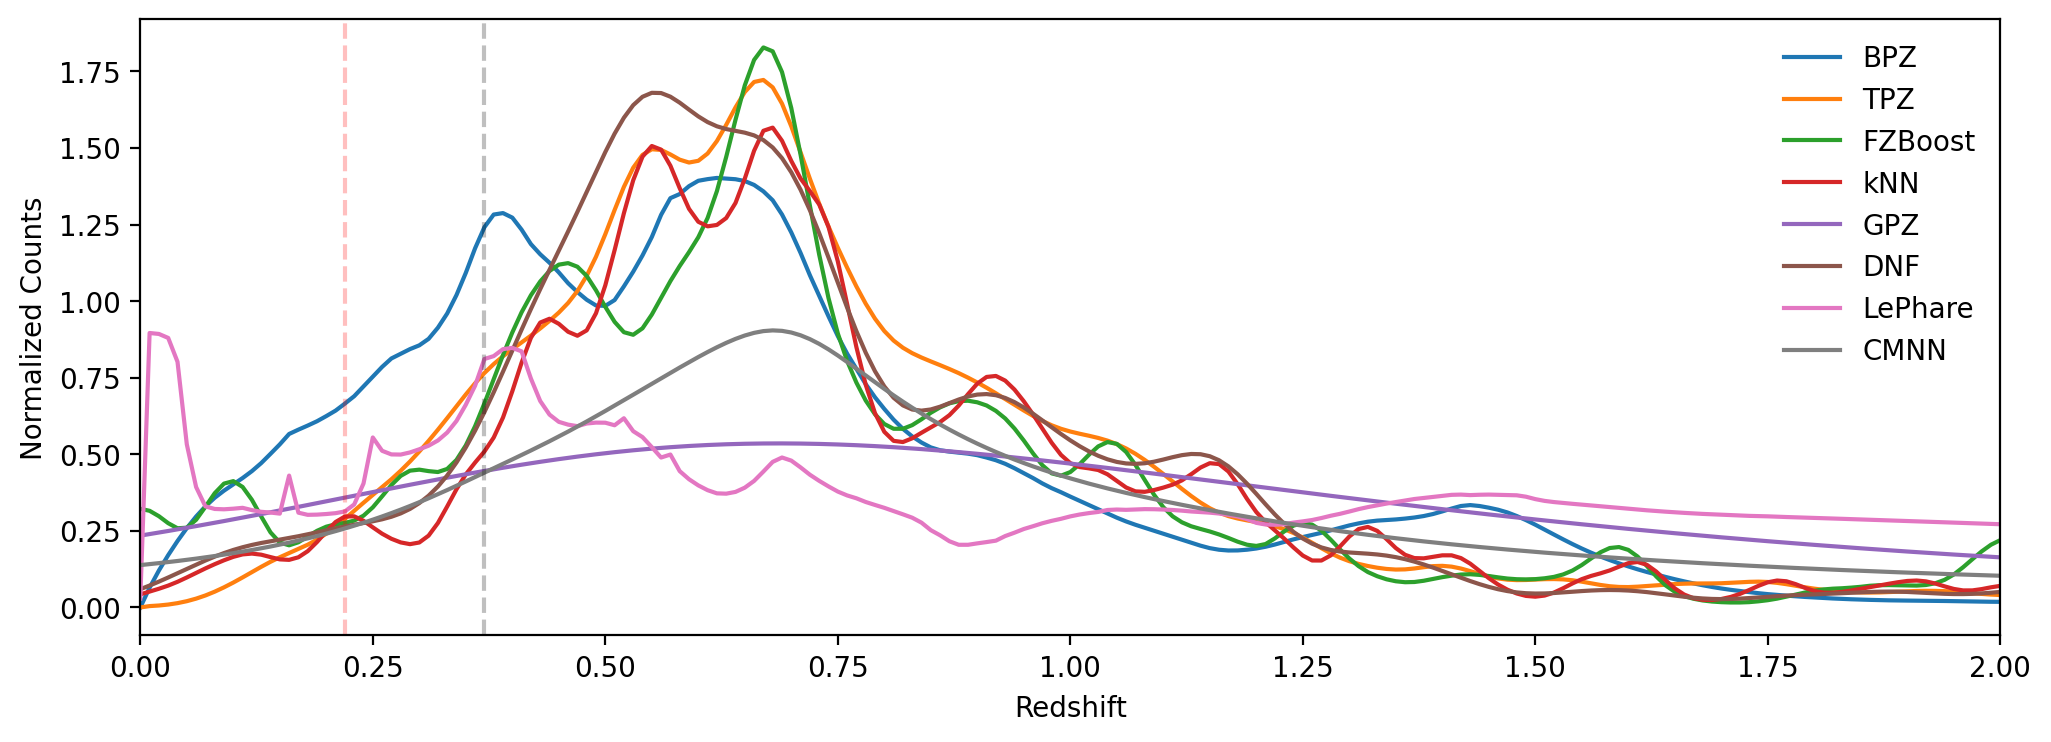

In [238]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, wl_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

#### Red Sequence Redshifts and N(z)s

In [241]:
pzo = pz_ests['objectId']

rs_ids = wl_pztable['objectId'][wl_pztable['all_redseq']]
rs_pz_filt = np.isin(all_pz_ids,rs_ids)

xs = np.linspace(0, 3, 301)

In [242]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = [] 

for alg in pz_algs:
    new_filt = np.logical_and(rs_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt, pz_sv38_pdf_dir)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 1097
On tpz we have 968
On fzboost we have 726
On knn we have 776


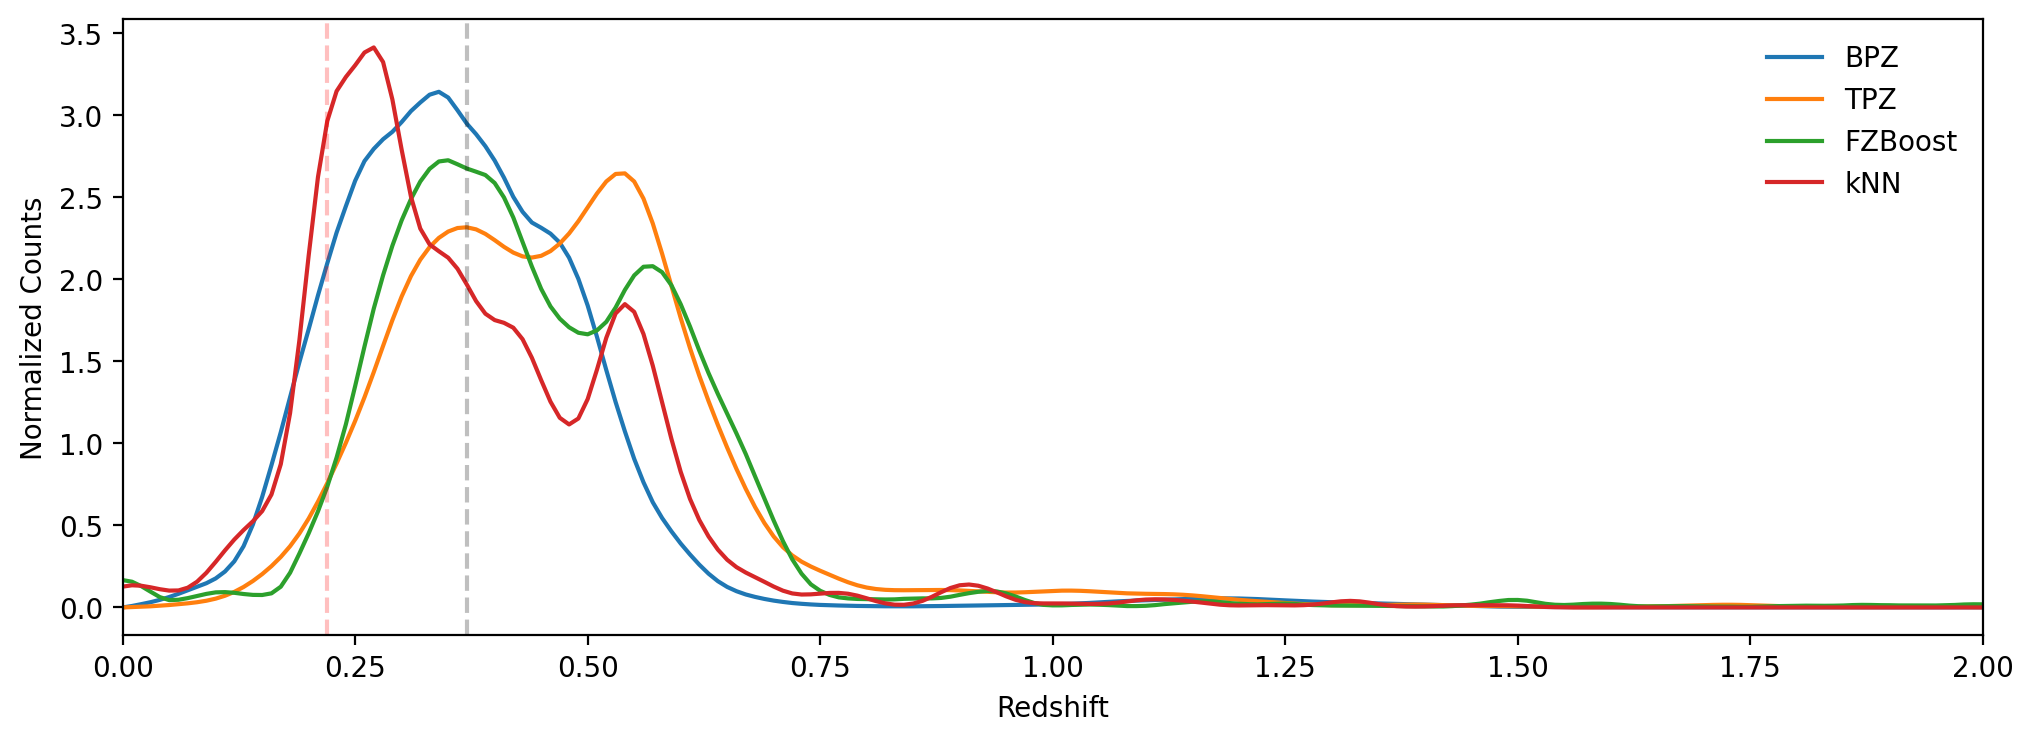

In [243]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

#### DESI Matched


In [376]:
# match_cc = Table.read('/home/a/adari/u/clusters/data/match_desi.fits')
# bands = list('griz')
# for b in bands:
#     match_cc.rename_column(f'{b}_cModelMag', f'{b}_cModel_mag')
#     match_cc.rename_column(f'{b}_gaap1p0Mag', f'{b}_gaap_mag')

match_cc = Table.read('cluster_data/desi_sv38_matches.fits')
match_cc_iron = Table.read('cluster_data/desi_sv38_ironmatches.fits')

In [444]:
non_ble_iron_filt = np.isin(match_cc_iron['objectId'], match_cc['objectId'])
non_ble = match_cc_iron[~non_ble_iron_filt]

Text(0.5, 0.01, '$i$-mag')

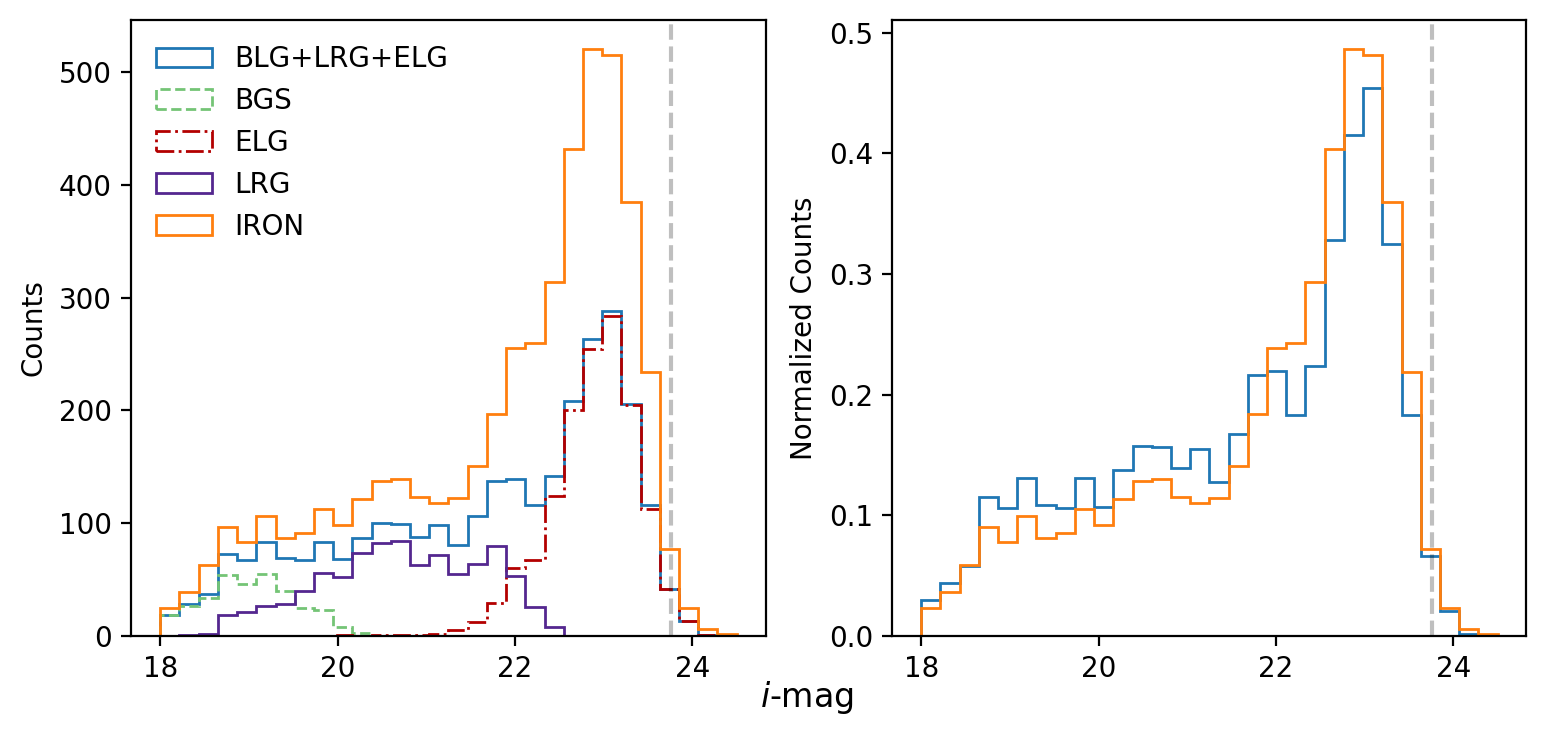

In [383]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))


sample_colors = ['#74c476','#b30000','#54278f']
sample_ls = ['--', '-.', '-']
ax[0].hist(match_cc['i_cModel_mag'], range=(18, 24.5), bins=30, histtype='step', label='BLG+LRG+ELG')
for i,k in enumerate(['BGS', 'ELG', 'LRG']):
    kfilt = match_cc['desi_sample'] == k
    ax[0].hist(match_cc['i_cModel_mag'][kfilt], range=(18, 24.5), label=k,
               bins=30, histtype='step', color=sample_colors[i], ls=sample_ls[i])
ax[0].hist(match_cc_iron['i_cModel_mag'], range=(18, 24.5), bins=30, histtype='step', label='IRON')
ax[0].axvline(23.76, ls='--', color='k', alpha=0.25)
ax[0].legend(frameon=False)
ax[0].set_ylabel("Counts")

ax[1].hist(match_cc['i_cModel_mag'], range=(18, 24.5), bins=30,
           histtype='step', label='BLG + RLG\n + ELG', density=True)
ax[1].hist(match_cc_iron['i_cModel_mag'], range=(18, 24.5), bins=30,
           histtype='step', label='IRON', density=True)
ax[1].axvline(23.76, ls='--', color='k', alpha=0.25)
ax[1].set_ylabel("Normalized Counts")
fig.supxlabel("$i$-mag")

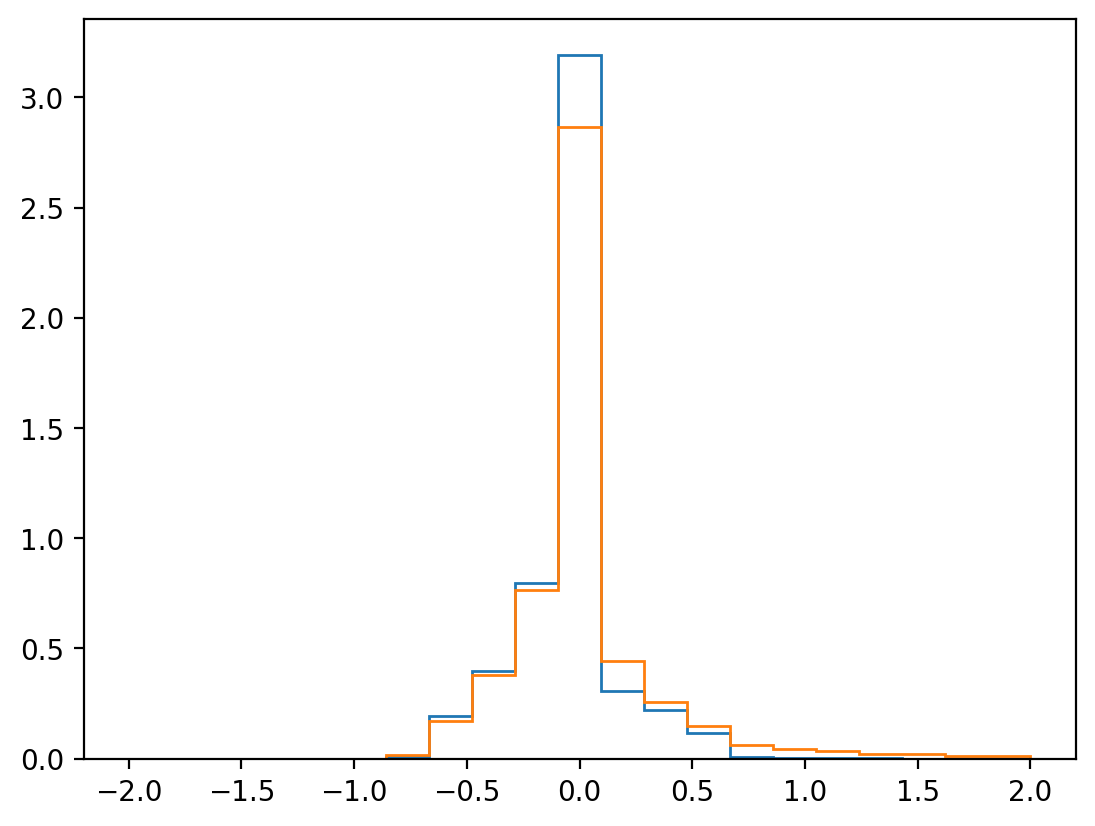

In [378]:
match_delta_z = (match_cc['dnf_z_median'] - match_cc['desi_z'])/(1+match_cc['desi_z'])
match_iron_delta_z = (match_cc_iron['dnf_z_median'] - match_cc_iron['desi_z'])/(1+match_cc_iron['desi_z'])
plt.hist(match_delta_z, range=(-2, 2), bins=21, density=True, histtype='step')
plt.hist(match_iron_delta_z, range=(-2, 2), bins=21, density=True, histtype='step');

Text(0.5, 0.01, '$i$-mag')

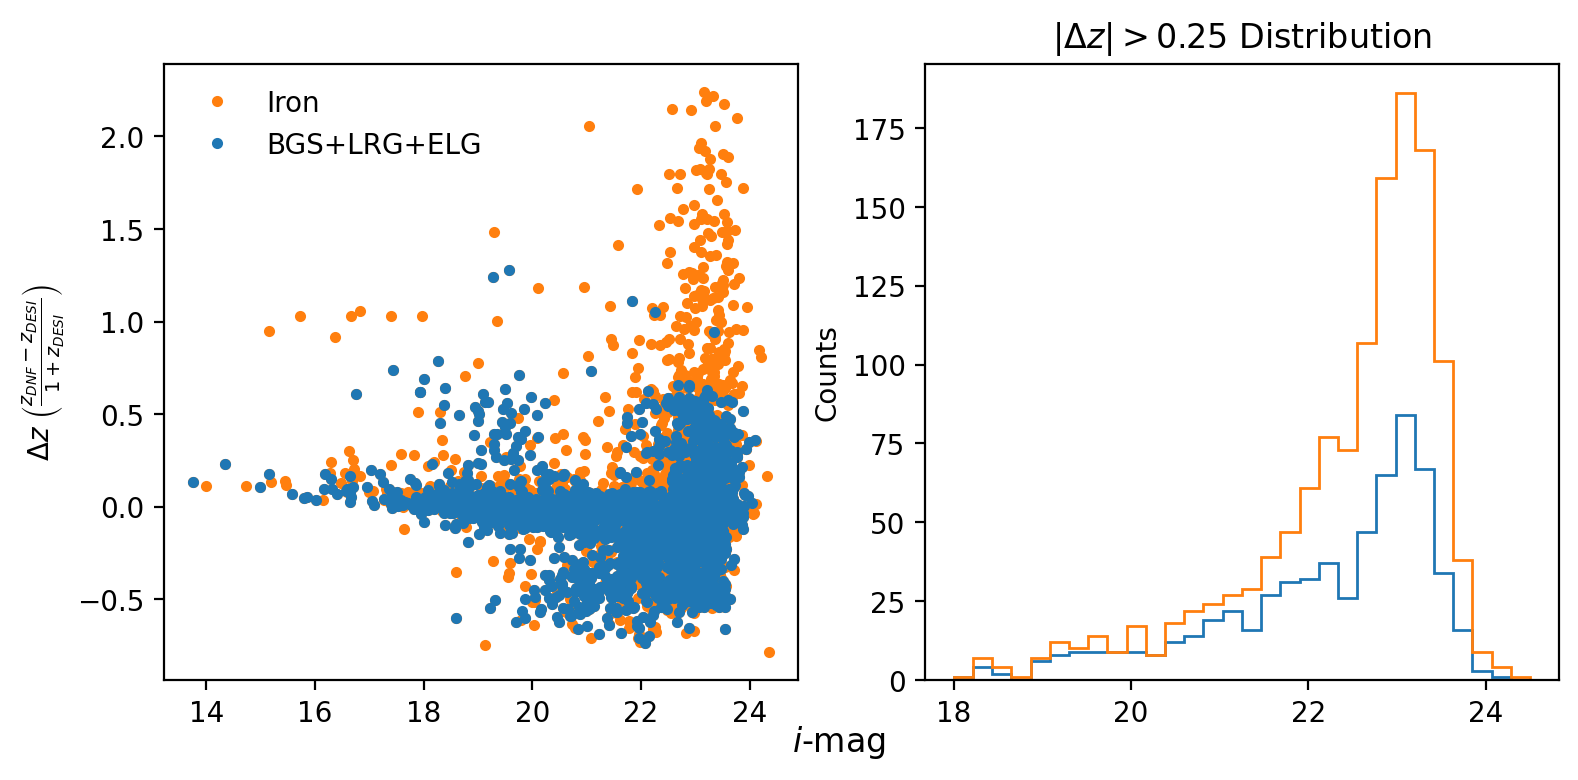

In [396]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))


ax[0].plot(match_cc_iron['i_cModel_mag'], match_iron_delta_z, '.', label='Iron', color='C1')
ax[0].plot(match_cc['i_cModel_mag'], match_delta_z, '.', label='BGS+LRG+ELG', color='C0')
ax[0].set_ylabel(r"$\Delta z$ $\left(\frac{z_{DNF} - z_{DESI}}{1 + z_{DESI}}\right)$")
ax[0].legend(frameon=False)

iron_delta_filt = np.abs(match_iron_delta_z) > 0.25
delta_filt = np.abs(match_delta_z) > 0.25
ax[1].hist(match_cc['i_cModel_mag'][delta_filt], 
           range=(18, 24.5), bins=30, histtype='step')
ax[1].hist(match_cc_iron['i_cModel_mag'][iron_delta_filt], 
           range=(18, 24.5), bins=30, histtype='step')
ax[1].set_title(r"$|\Delta z| > 0.25$ Distribution")
ax[1].set_ylabel("Counts")

fig.supxlabel("$i$-mag")

Text(0, 0.5, 'g-i')

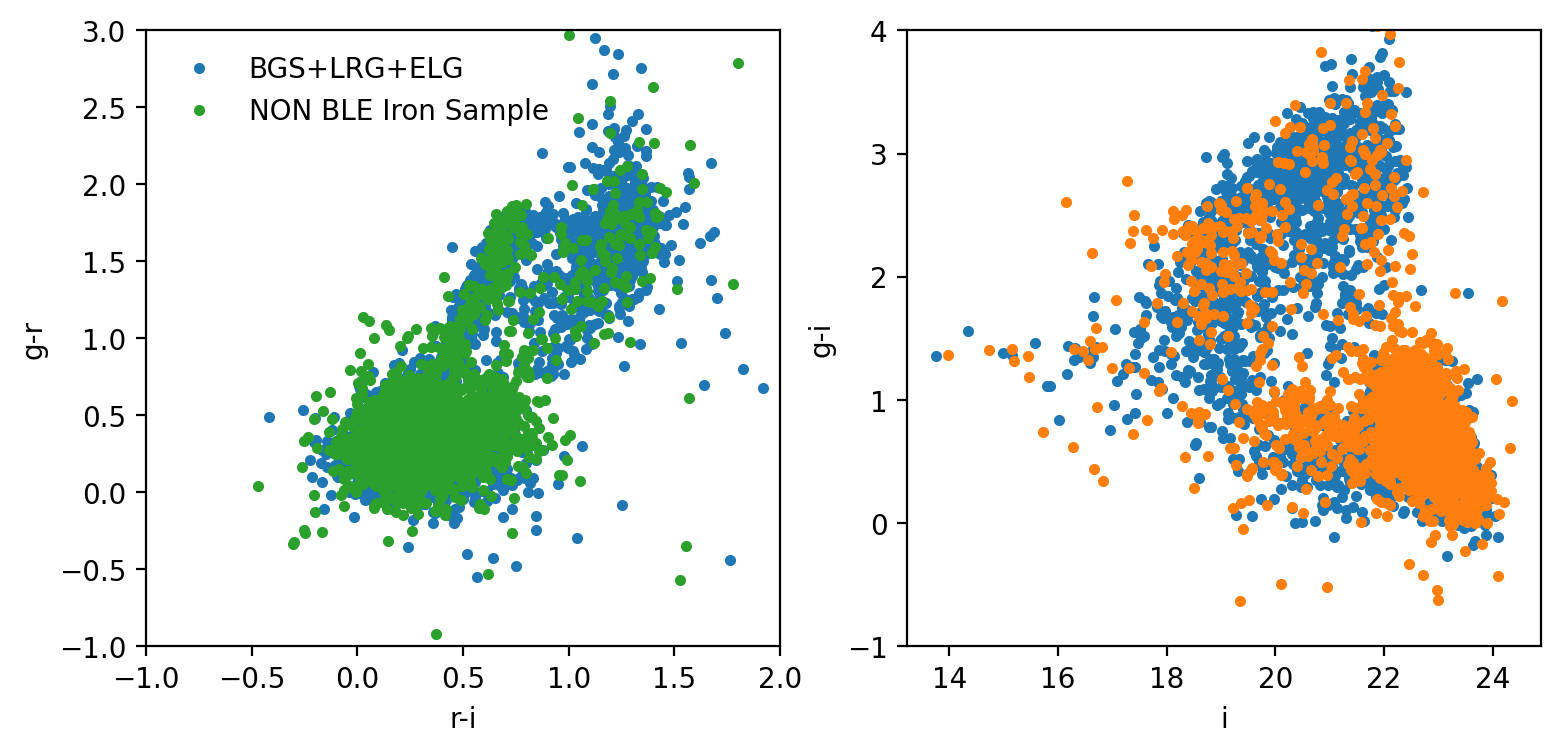

In [464]:

fig, ax = plt.subplots(ncols=2, figsize=(9,4))

# ax[0].plot(match_cc_iron['ri'], match_cc_iron['gr'], '.', color='C1', label='NON BLE Iron Sample')
ax[0].plot(match_cc['ri'], match_cc['gr'], '.', color='C0', label='BGS+LRG+ELG')
ax[0].plot(non_ble['ri'], non_ble['gr'], '.', color='C2', label='NON BLE Iron Sample')

ax[0].legend(frameon=False)
ax[0].set_xlim(-1, 2)
ax[0].set_ylim(-1, 3)
ax[0].set_xlabel("r-i")
ax[0].set_ylabel("g-r")

ax[1].plot(match_cc['i_cModel_mag'], match_cc['gi'], '.', color='C0')
ax[1].plot(non_ble['i_cModel_mag'], non_ble['gi'], '.', color='C1')
# ax[1].set_xlim(-1, 3)
ax[1].set_ylim(-1, 4)
ax[1].set_xlabel("i")
ax[1].set_ylabel("g-i")

Text(0, 0.5, 'g-i')

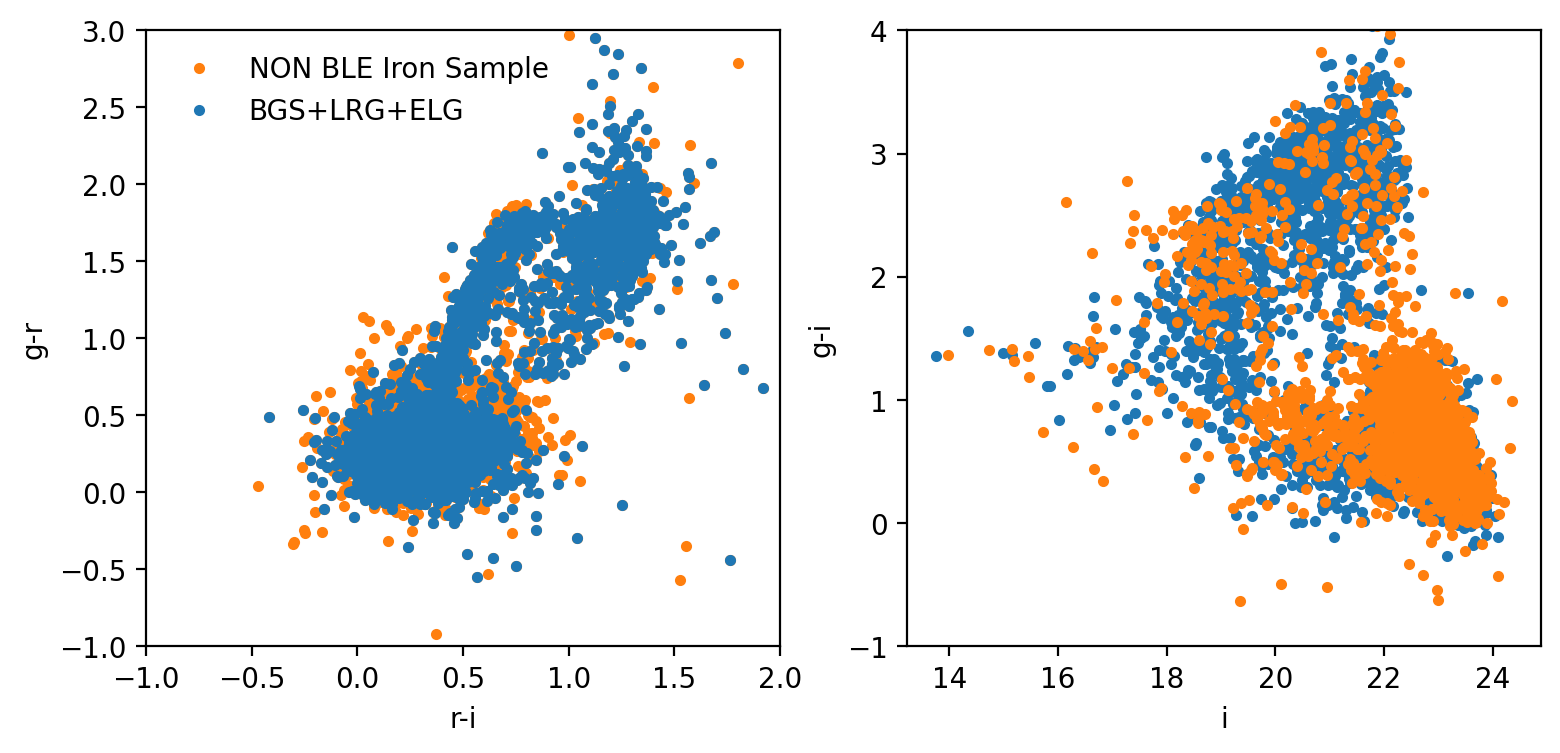

In [465]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

ax[0].plot(match_cc_iron['ri'], match_cc_iron['gr'], '.', color='C1', label='NON BLE Iron Sample')
ax[0].plot(match_cc['ri'], match_cc['gr'], '.', color='C0', label='BGS+LRG+ELG')
# ax[0].plot(non_ble['ri'], non_ble['gr'], '.', color='C2', label='NON BLE Iron Sample')

ax[0].legend(frameon=False)
ax[0].set_xlim(-1, 2)
ax[0].set_ylim(-1, 3)
ax[0].set_xlabel("r-i")
ax[0].set_ylabel("g-r")

ax[1].plot(match_cc['i_cModel_mag'], match_cc['gi'], '.', color='C0')
ax[1].plot(non_ble['i_cModel_mag'], non_ble['gi'], '.', color='C1')
# ax[1].set_xlim(-1, 3)
ax[1].set_ylim(-1, 4)
ax[1].set_xlabel("i")
ax[1].set_ylabel("g-i")

In [291]:
# fig, ax = plt.subplots(ncols=2, figsize=(6,4))

# ax[0].scatter(match_cc1['desi_z'], match_cc1['dnf_z_median'], s=2, label='Original')
# ax[1].scatter(match_cc['desi_z'], match_cc['dnf_z_median'], s=2, label='IRON')
# for xx in ax:
#     xx.set_xlim(0, 1.5)
#     xx.set_ylim(0, 1.5)

In [ ]:
match_cc = Table.read('cluster_data/desi_sv38_matches.fits')
match_cc_iron = Table.read('cluster_data/desi_sv38_ironmatches.fits')

In [359]:
match_mask = get_masks(match_cc)
match_cc = match_cc[match_mask]

In [360]:
match_cc = match_cc[match_cc['i_cModel_mag'] < 23.76]

In [361]:
match_cc = apply_redsequence_noisy(match_cc, sigma=1, mag_lim=23.76)
pz_diffs(match_cc, pz_algos)

/tmp/ipykernel_5528/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_5528/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_5528/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))


In [362]:
redseq_match = match_cc[match_cc['all_redseq']]
print(len(redseq_match))

64


In [296]:
pzo = pz_ests['objectId']

desi_rs_ids = redseq_match['objectId']
rs_desi_filt = np.isin(pzo,desi_rs_ids)

xs = np.linspace(0, 3, 301)

In [255]:
pz_algs = ['bpz', 'dnf', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algos:
    # if alg=='gpz':
    #     new_filt = rs_desi_filt
    # else:
    #     new_filt = np.logical_and(rs_desi_filt, pz_ests[f'{alg}_diff'] < 0.25)
    new_filt = rs_desi_filt
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt, pz_dir=pz_sv38_pdf_dir)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 64
On tpz we have 64
On fzboost we have 64
On knn we have 64
On gpz we have 64
On dnf we have 64
On lephare we have 64
On cmnn we have 64


In [256]:
pdf_scale_factor = np.zeros(len(quality_pdfs))
for i,qpdf in enumerate(quality_pdfs):
    pdf_scale_factor[i] = 1/(integrate.trapezoid(qpdf, xs))

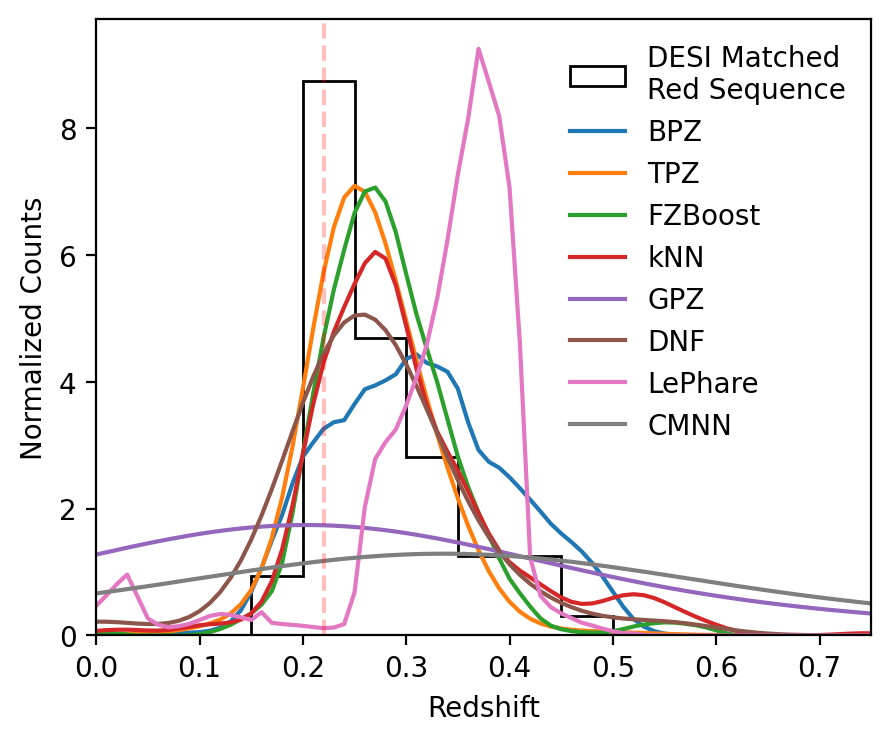

In [257]:
fig, ax = plt.subplots(1, figsize=(5, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']

plot_bins = np.linspace(0.0, 0.5, 11)
# ax.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25,
#         label="DESI Matched\nRed Sequence", density=True, color='k', ls='--')
ax.hist(redseq_match['desi_z'], histtype='step', bins=plot_bins,
        label="DESI Matched\nRed Sequence", density=True, color='k', ls='-')
for i, alg in enumerate(pz_algos):
    ax.plot(xs, quality_pdfs[i] * pdf_scale_factor[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, .75)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
# ax.set_ylabel("Normalized Counts")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

In [258]:
# plt.axvline(0.22, ls='--', color='k', alpha=0.2)
# plt.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25, label="Matched Red Sequence")
# plt.xlabel("Spectroscopic Redshift")
# plt.ylabel("Counts")

In [365]:
R2 = 1 - (match_cc['i_ixxPSF']+match_cc['i_iyyPSF'])/(match_cc['shape_xx']+match_cc['shape_yy'])
match_cc['res'] = R2

In [366]:
c1 = SkyCoord(match_cc['coord_ra']*u.deg, match_cc['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
match_cc['sep'] = sep.deg

In [367]:
match_wl_filt = get_wlfilt(match_cc, mag_lim=23.76, apply_sep=True)
wl_match = match_cc[match_wl_filt]

After WL cuts: 279


In [300]:
rs_match = match_cc[match_cc['all_redseq']]

In [301]:
pz_algs = ['bpz', 'dnf', 'fzboost', 'knn']

pzo = pz_ests['objectId']
rs_filt = np.isin(pzo, rs_match['objectId'])
source_filt = np.isin(pzo, wl_match['objectId'])

rs_pdf, _, xs = get_pdfs('dnf', rs_filt, pz_dir=pz_sv38_pdf_dir)
rs_scalefactor = 1/integrate.trapezoid(rs_pdf, xs)
wl_pdf, _, xs = get_pdfs('dnf', source_filt, pz_dir=pz_sv38_pdf_dir)
wl_scalefactor = 1/integrate.trapezoid(wl_pdf, xs)

Text(0.5, 0.01, 'Photo-z')

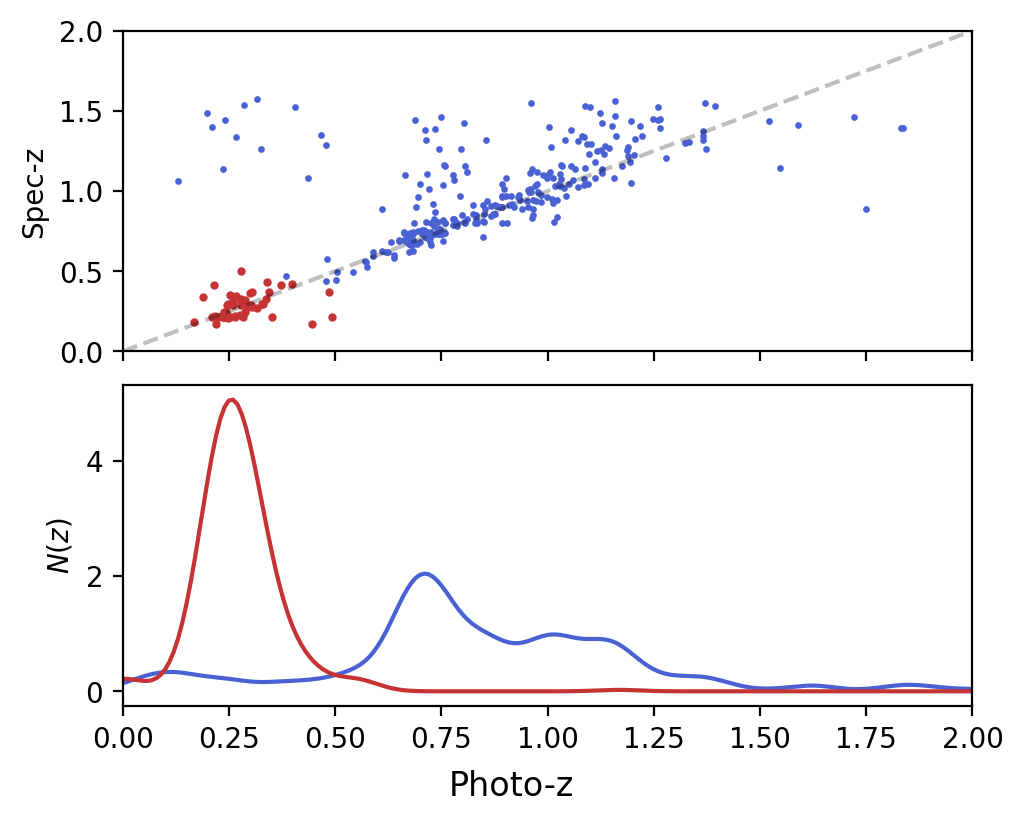

In [303]:
fig, ax = plt.subplots(nrows=2, figsize=(5,4), layout='constrained', sharex=True)

rs_filt = match_cc['all_redseq']
cmap = cm.coolwarm
rs_color = cmap(0.95)
source_color = cmap(0.05)

ax[0].scatter(match_cc['dnf_z_median'][rs_filt], match_cc['desi_z'][rs_filt],  s=4, color=rs_color)
ax[0].scatter(wl_match['dnf_z_median'], wl_match['desi_z'], s=2, color=source_color, alpha=1)
ax[0].plot([0,10], [0,10], ls='--', color='k', alpha=0.25)
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2)
ax[0].set_ylabel("Spec-z")

plot_bins = np.linspace(0.0, 0.5, 11)

ax[1].plot(xs, wl_pdf * wl_scalefactor, color=source_color)
ax[1].plot(xs, rs_pdf * rs_scalefactor, color=rs_color)
ax[1].set_xlim(0, 2)
ax[1].set_ylabel("$N(z)$")
# ax[1].set_ylabel("Normalized Counts")

fig.supxlabel("Photo-z")
# fig.suptitle("DESI IRON Catalog")
# fig.suptitle("BGS x LRG x ELG")

## ECDFS $N(z)$ from color cuts

#### Load ECDFS Photo-Z Data

In [254]:
bands = list('ugrizy')
ecdfs_cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
ecdfs_gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]

ecdfs_object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag', 'shape_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + ecdfs_cmodel_bands + ecdfs_gaap_bands

ecdfs_tracts = [5063, 4849, 4848]


In [255]:
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)
pz_ests = Table.from_pandas(pz_ests)

In [256]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [257]:
dp1_catalog, preclean_ecdfs = load_pz_photomdata(tracts=ecdfs_tracts, columns=ecdfs_object_req_cols)
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [258]:
ecdfs_table = join(dp1_catalog, pz_ests, keys='objectId')
ecdfs_table.add_index('objectId')
ecdfs_table = Table.filled(ecdfs_table, fill_value=np.nan)

#### Apply Quality + RS Cuts

In [259]:
ecdfs_mk = ecdfs_mask(ecdfs_table)
ecdfs_table = ecdfs_table[ecdfs_mk]

In [260]:
ecdfs_wl = get_wlfilt(ecdfs_table, mag_lim=23.76, apply_sep=False)
ecdfs_wl_table = ecdfs_table[ecdfs_wl]

After WL cuts: 37692


In [261]:
ecdfs_wl_table = apply_redsequence_noisy(ecdfs_wl_table)
# ecdfs_wl_table = apply_redsequence(ecdfs_wl_table)

/tmp/ipykernel_149/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))


Text(0.5, 0.01, 'cModel $i$-mag')

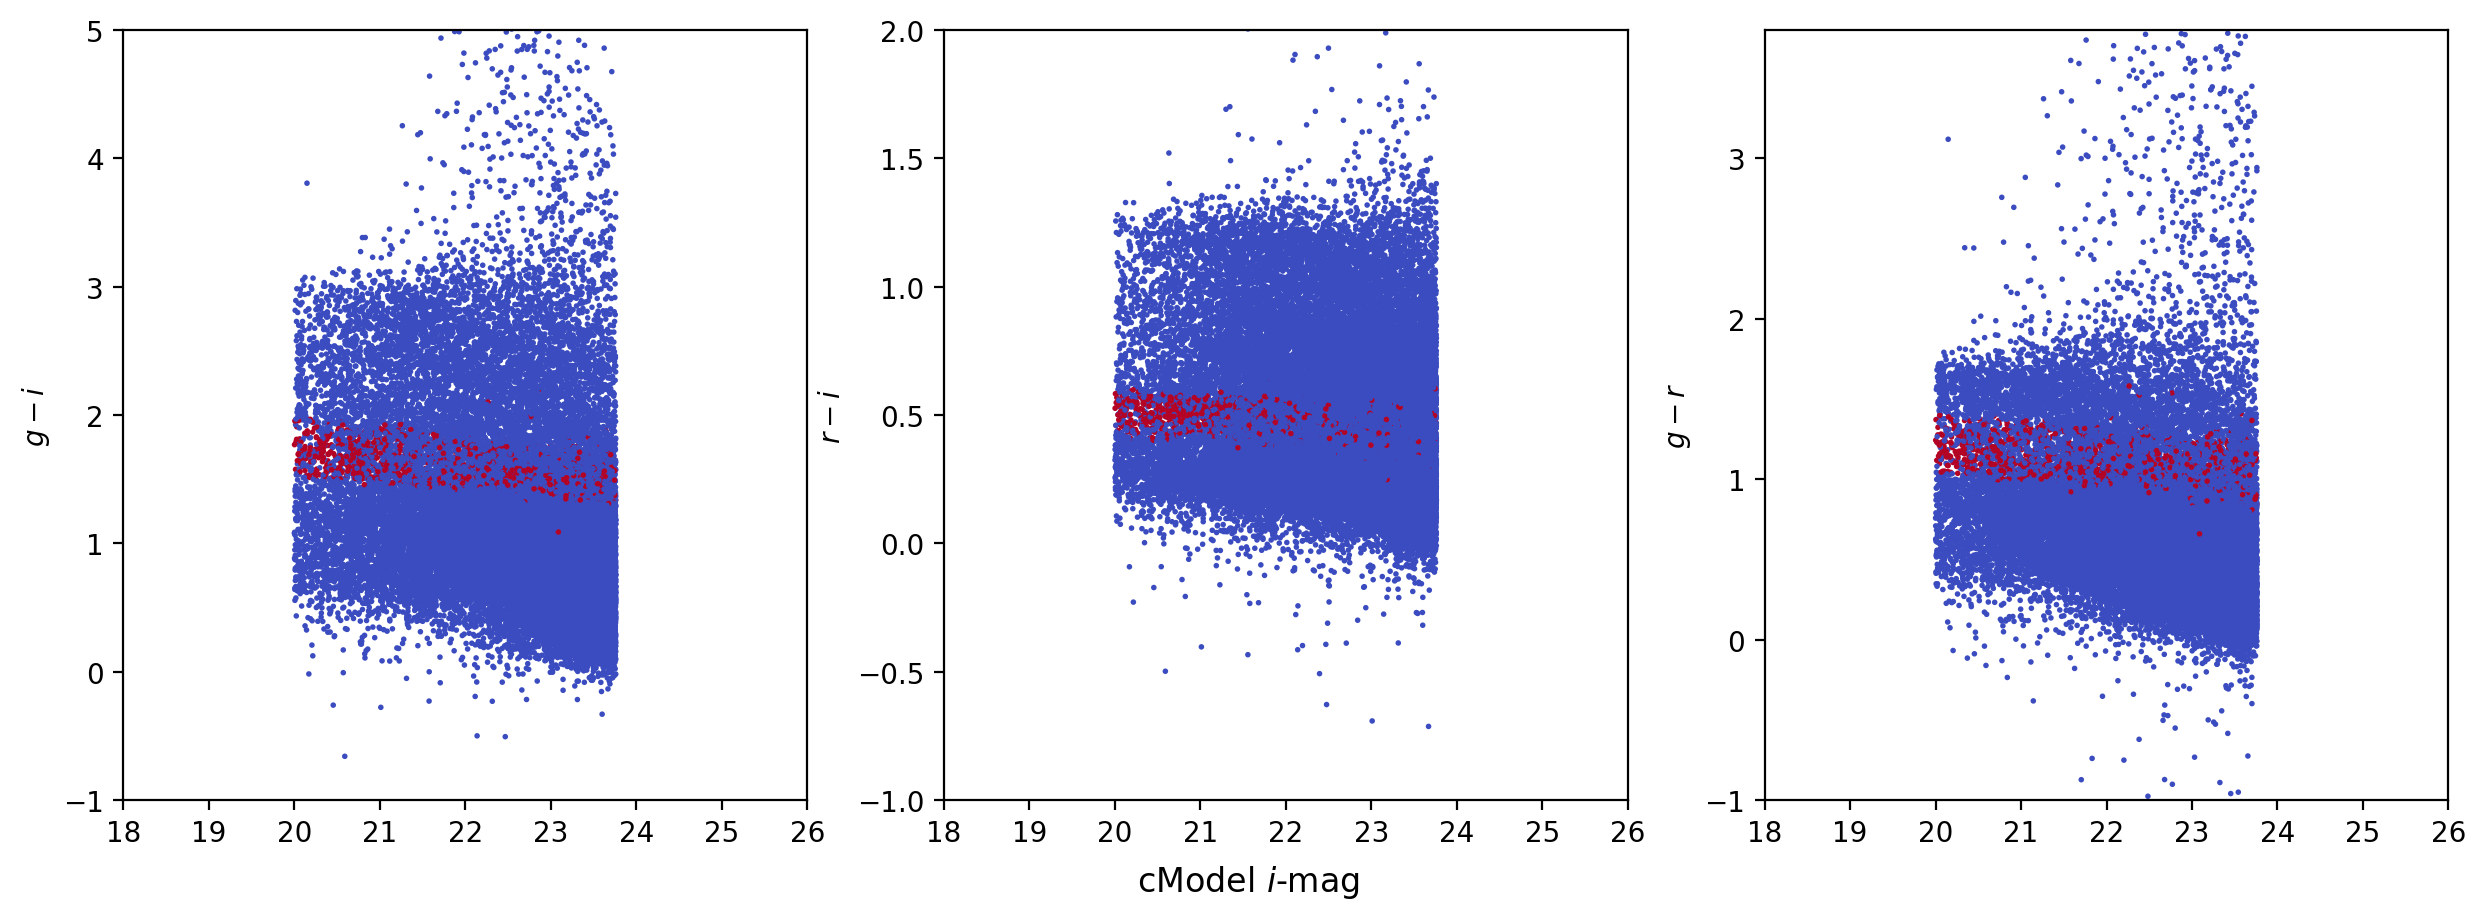

In [262]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(ecdfs_wl_table['i_cModel_mag'], ecdfs_wl_table[col], marker='.', s=4,
                  c=ecdfs_wl_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(col_name[i])
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $i$-mag")

#### $N(z)$

In [263]:
pzo = pz_ests['objectId']
ecdfs_pzo = ecdfs_wl_table['objectId']

ecdfs_nz_filt = np.isin(pzo, ecdfs_pzo)

In [266]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']
ecdfs_nz_pdfs = np.zeros((len(pz_algs), 301))

for cc in ['all', 'gi', 'ri', 'gr']:
    ecdfs_nz_pdfs = np.zeros((len(pz_algs), 301))

    cc_ids = ecdfs_wl_table['objectId'][~ecdfs_wl_table[f'{cc}_redseq']]

    for i,alg in enumerate(pz_algs):
        new_filt = np.isin(pzo, cc_ids)
        # new_filt = ecdfs_nz_filt
        print(f"On {alg} we have {np.sum(new_filt)}")
        pdf, _, xs = get_pdfs(alg, new_filt, pz_ecdfs_pdf_dir)
        c = gc.collect()
        ecdfs_nz_pdfs[i,:] = pdf
    np.save(f"cluster_data/ecdfs_nz_{cc}noisy.npy", ecdfs_nz_pdfs)

On bpz we have 36497
On tpz we have 36497
On fzboost we have 36497
On knn we have 36497
On gpz we have 36497
On dnf we have 36497
On lephare we have 36497
On cmnn we have 36497
On bpz we have 33132
On tpz we have 33132
On fzboost we have 33132
On knn we have 33132
On gpz we have 33132
On dnf we have 33132
On lephare we have 33132
On cmnn we have 33132
On bpz we have 28297
On tpz we have 28297
On fzboost we have 28297
On knn we have 28297
On gpz we have 28297
On dnf we have 28297
On lephare we have 28297
On cmnn we have 28297
On bpz we have 32957
On tpz we have 32957
On fzboost we have 32957
On knn we have 32957
On gpz we have 32957
On dnf we have 32957
On lephare we have 32957
On cmnn we have 32957


In [269]:
ecdfs_nz_pdfs = np.load("cluster_data/ecdfs_nz_allnoisy.npy")

Text(0.5, 1.0, 'ECDFS All Colors Red Sequence $N(z)$')

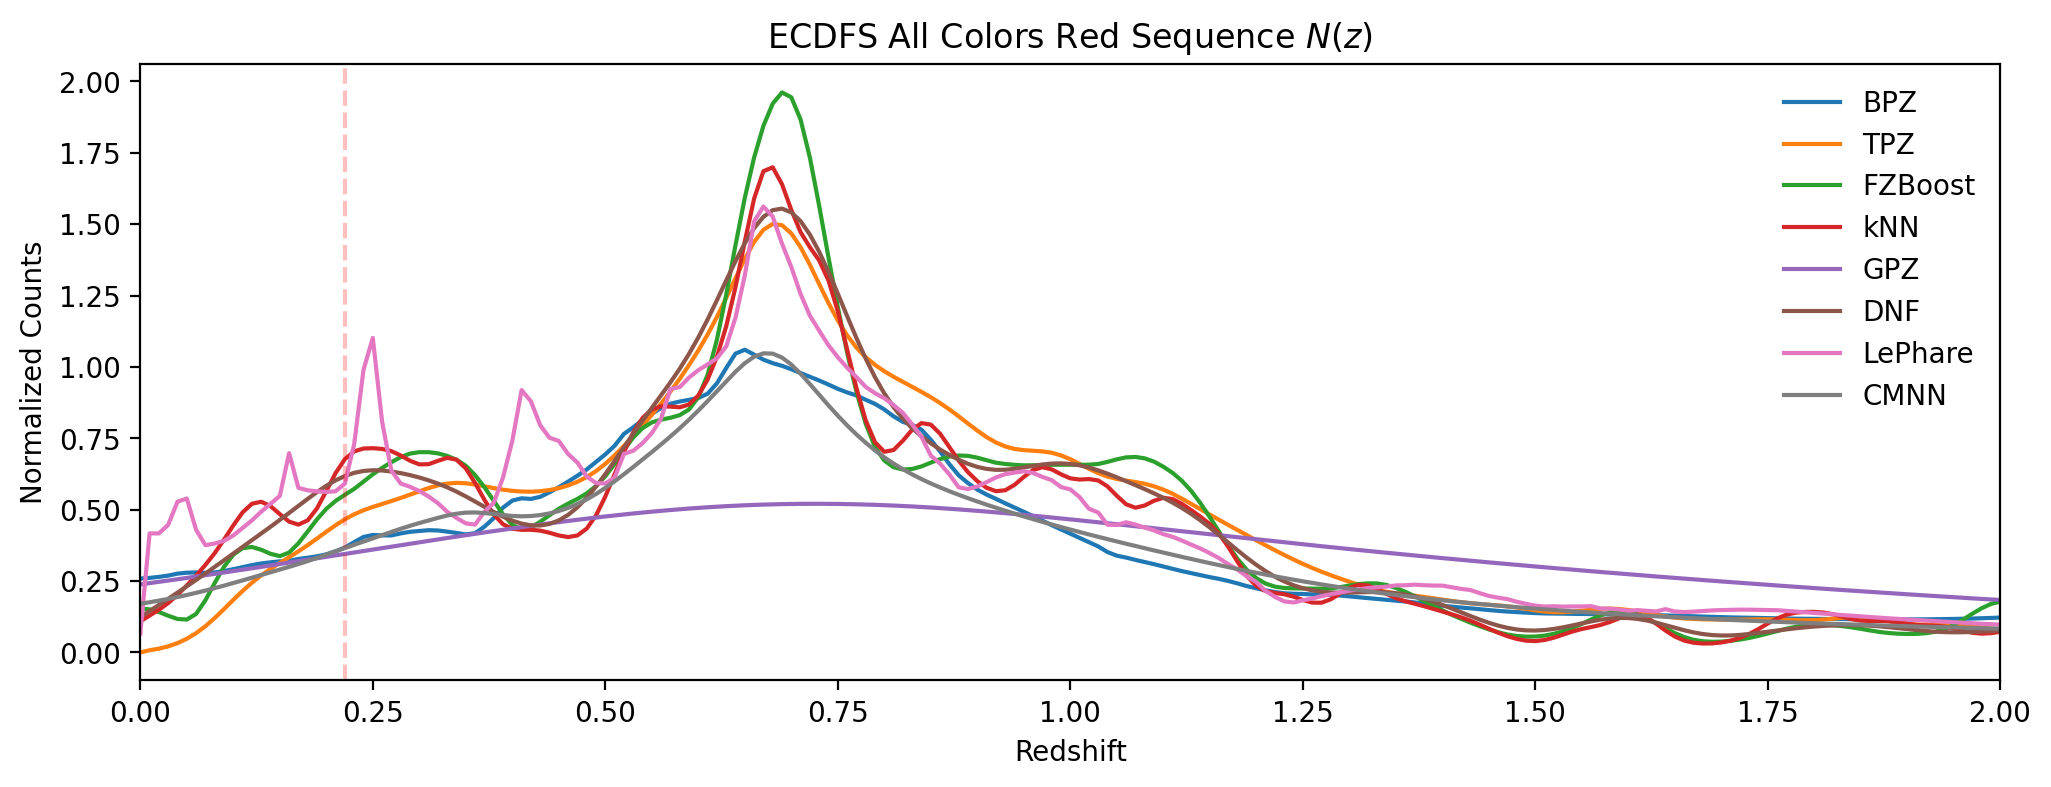

In [270]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, ecdfs_nz_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
plt.title("ECDFS All Colors Red Sequence $N(z)$")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

In [271]:
# np.save('cluster_data/ecdfs_nz_allrs.npy', ecdfs_nz_pdfs)

## $N(z)$ Comparison

In [518]:
ecdfs_nz_pdfs = np.load("cluster_data/ecdfs_nz_allnoisy.npy")
# ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']
wl_pdfs = np.load('cluster_data/sv38_nz_allnoisy.npy')
# ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']

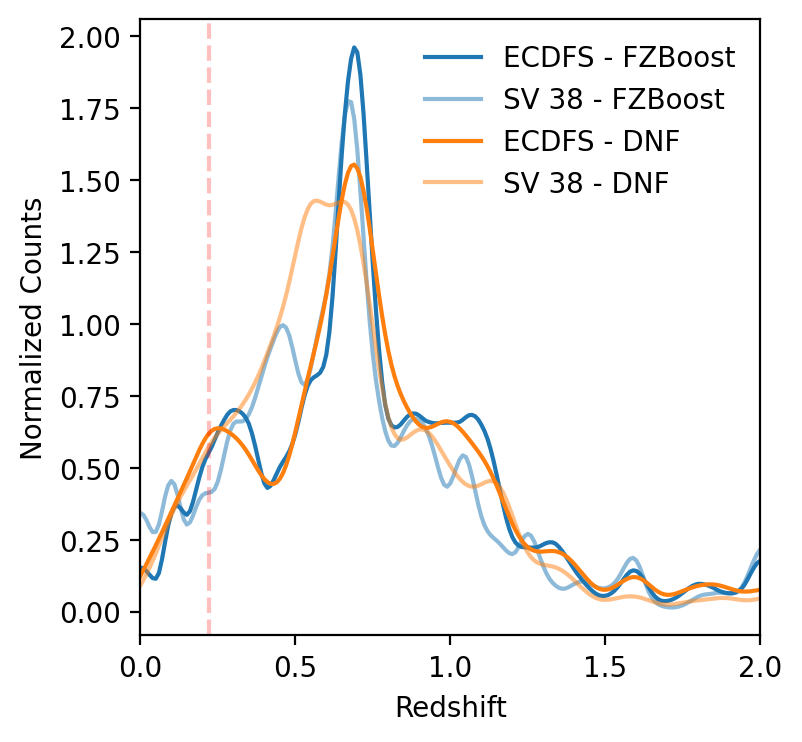

In [538]:
fig, ax = plt.subplots(1, figsize=(4, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']

for i,ndx in enumerate([2,5]):
    ax.plot(xs, ecdfs_nz_pdfs[ndx], label=f"ECDFS - {label[ndx]}", ls='-', color=f'C{i}')
    ax.plot(xs, wl_pdfs[ndx], label=f"SV 38 - {label[ndx]}", ls='-', color=f'C{i}', alpha=0.5)    



ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# plt.title(f"All Colors Red Sequence $N(z)$")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

## Profile Comparison

In [92]:
with open(f'./cluster_data/technote/profile_all_y3', 'rb') as f:
    profile = pickle.load(f)

In [195]:
cc_types = ['all', 'gi', 'ri', 'gr']
profiles = []

for cc in cc_types:
    with open(f'./cluster_data/technote/profile_{cc}noisy_y3_narrowbins', 'rb') as f:
        profile = pickle.load(f)
        profiles.append(profile.profile)

In [196]:
cc_types = ['all', 'gi', 'ri', 'gr']
noisy_profiles = []

for cc in cc_types:
    with open(f'./cluster_data/technote/profile_{cc}noisy_masked_y3_narrowbins', 'rb') as f:
        profile = pickle.load(f)
        noisy_profiles.append(profile.profile)

Text(0.5, 1.0, 'Noisy Red Sequence + Mask')

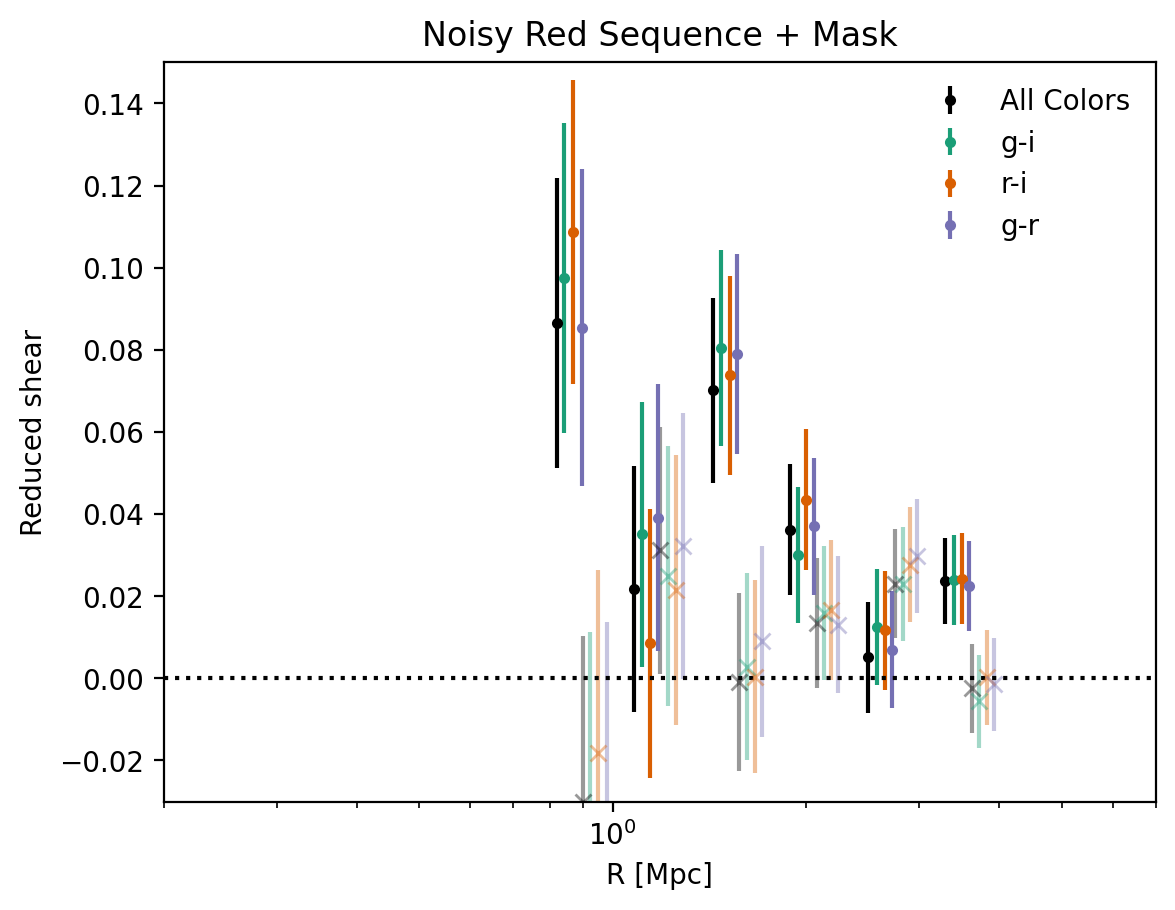

In [197]:

colors = ['#000000', '#1b9e77','#d95f02','#7570b3']
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(noisy_profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.4)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.15])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
plt.title("Noisy Red Sequence + Mask")
# plt.title("HSM Profile with Color Cuts - DP1")

Text(0.5, 1.0, 'Noisy Red Sequence')

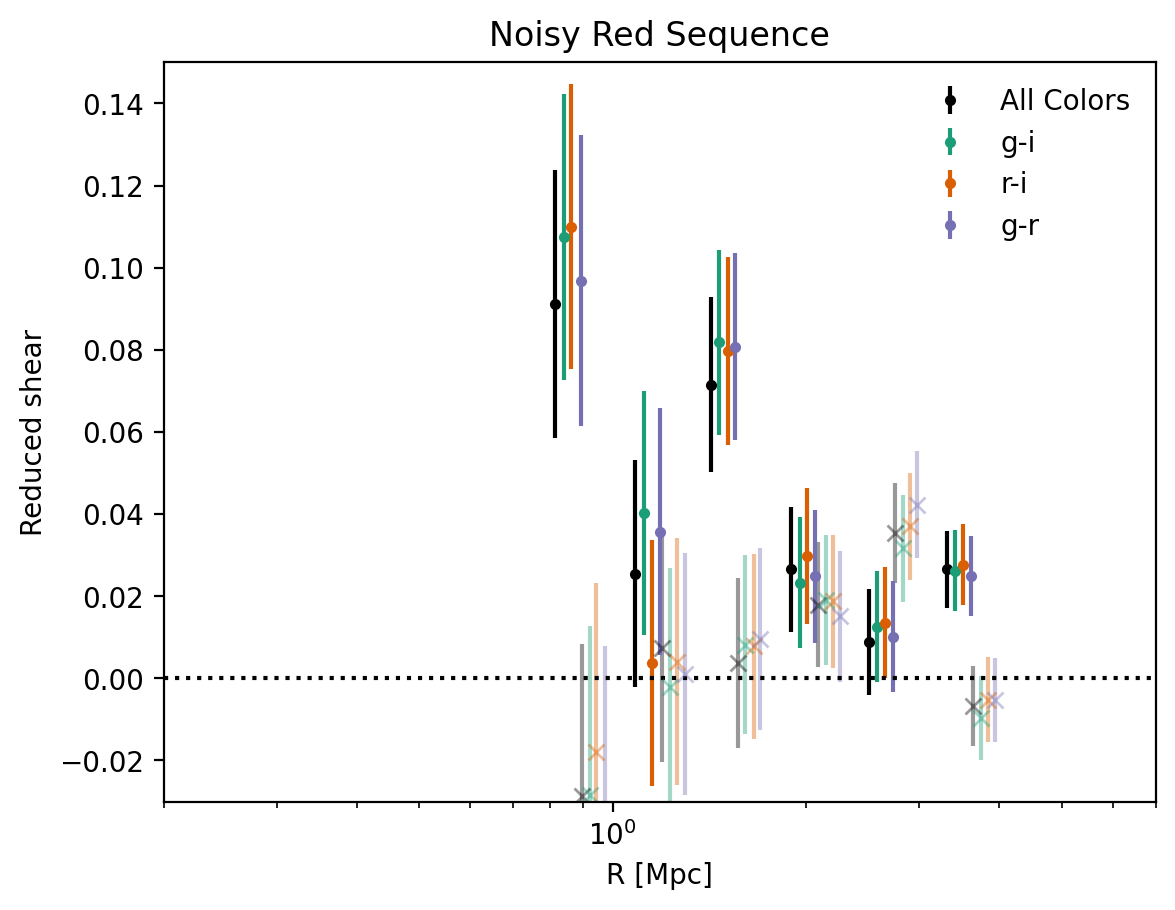

In [198]:

colors = ['#000000', '#1b9e77','#d95f02','#7570b3']
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.4)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.15])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
plt.title("Noisy Red Sequence")
# plt.title("HSM Profile with Color Cuts - DP1")

In [144]:
# pz_types = ['bpz0.37', 'tpz0.37', 'fzboost0.37', 'knn0.37']
pz_types = ['gpz0.37', 'dnf0.37', 'lephare0.37', 'cmnn0.37']
pz_profiles = []

for cc in pz_types:
    with open(f'./cluster_data/technote/profile_{cc}_y3', 'rb') as f:
        profile = pickle.load(f)
        pz_profiles.append(profile.profile)

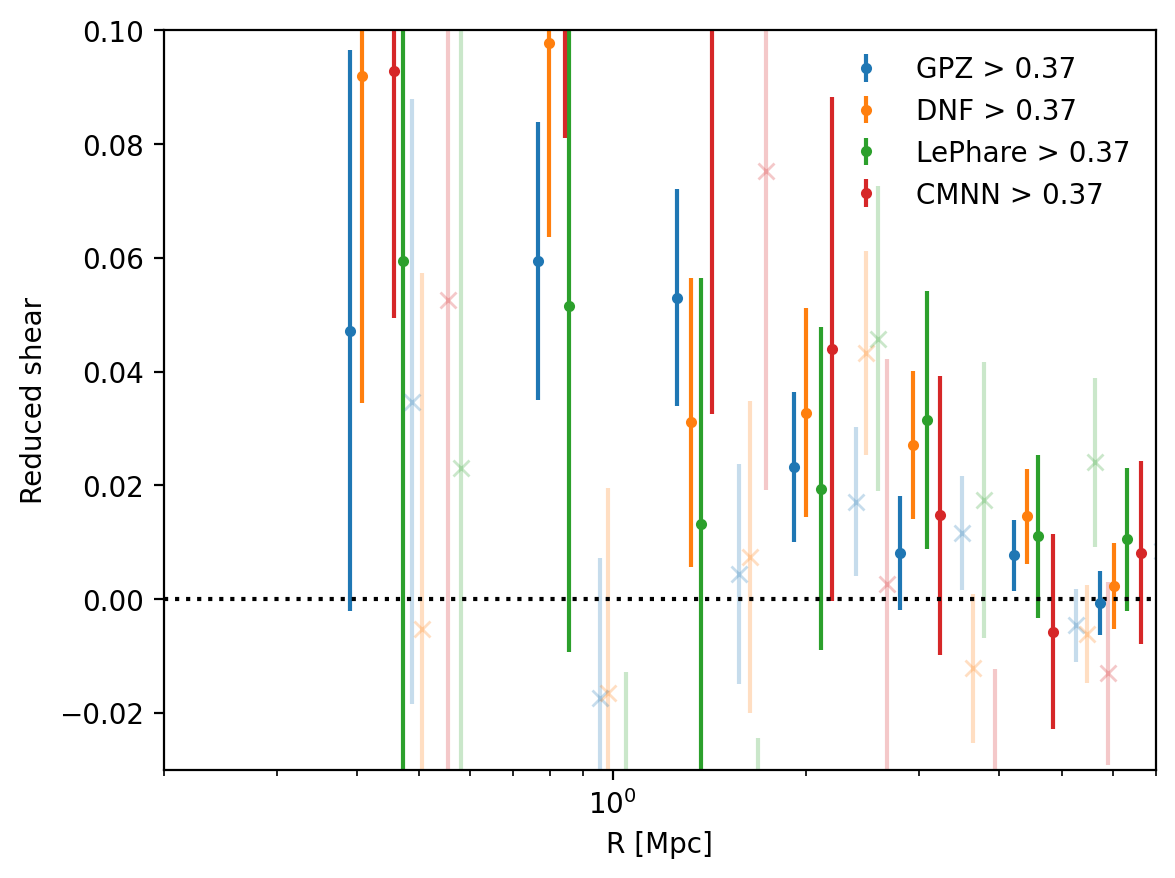

In [145]:

cmap = cm.tab10
labels = ['BPZ > 0.37', 'TPZ > 0.37',  'FZBoost > 0.37', 'kNN > 0.37']
labels = ['GPZ > 0.37', 'DNF > 0.37',  'LePhare > 0.37', 'CMNN > 0.37']
# colors = [cmap(0), cmap(1.),cmap(.25), cmap(0.75)]
colors = [cmap(i) for i in range(4)]


for i,profile in enumerate(pz_profiles):
    plt.errorbar(profile['radius']*(1+.05*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.25+.05*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.25)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with PZ Cuts - DP1")

### Shear Ratio Test

In [206]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [199]:
# From Shenming's CLMM demo on using HSC data
def apply_shear_calibration(e1_0, e2_0, e_rms, m, c1, c2, weight):
    R = 1.0 - np.sum(weight * e_rms**2.0) / np.sum(weight)
    m_mean = np.sum(weight * m) / np.sum(weight)
    c1_mean = np.sum(weight * c1) / np.sum(weight)
    c2_mean = np.sum(weight * c2) / np.sum(weight)
    print("R, m_mean, c1_mean, c2_mean: ", R, m_mean, c1_mean, c2_mean)

    g1 = (e1_0 / (2.0 * R) - c1) / (1.0 + m_mean)
    g2 = (e2_0 / (2.0 * R) - c2) / (1.0 + m_mean)

    return g1, g2


In [207]:
algos = ['knn', 'fzboost', 'bpz', 'tpz']
bin_names = ['bin1', 'bin2']

In [262]:
algo_profiles = {}

for calib_type in algos:
    for bn in bin_names:
        print(f"Working on {calib_type} {bn}")
    
        postcuts_filename = f'technote/shear-ratio_{calib_type}{bn}_DP1.fits'
        calib_filename = f'technote/shear_ratio_calib_{calib_type}_{bn}.fits'
    
        with fits.open(f'cluster_data/{calib_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            table = Table(data)
    
        with fits.open(f'cluster_data/{postcuts_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            wl_table = Table(data)
    
        e_rms = table["ishape_hsm_regauss_derived_rms_e"]
        m = table["ishape_hsm_regauss_derived_shear_bias_m"]
        c1 = table["ishape_hsm_regauss_derived_shear_bias_c1"]
        c2 = table["ishape_hsm_regauss_derived_shear_bias_c2"]
        weight = table["ishape_hsm_regauss_derived_shape_weight"]
        # weight = np.ones(len(c1))
    
        g1, g2 = apply_shear_calibration(wl_table['i_hsmShapeRegauss_e1'], wl_table['i_hsmShapeRegauss_e2'], e_rms, m, c1, c2, weight)
    
        galcat = GCData()
        galcat['ra'] = wl_table['coord_ra']
        galcat['dec'] = wl_table['coord_dec']
        galcat['e1'] = g1
        galcat['e2'] = g2
        galcat['e_err'] = wl_table['i_hsmShapeRegauss_sigma']/2
        galcat['hsm_weight'] = weight
        galcat['id'] = np.arange(len(wl_table))
        galcat['z'] = np.zeros(len(wl_table))
        # galcat['z'] = wl_table['fzb_z_median']
    
        ra_bcg = 37.865017
        dec_bcg = 6.982205
        
        cluster_id = "Abell 360"
        gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')
    
        gc_object1.compute_tangential_and_cross_components(add=True);
        bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7]) 
     
        gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, 
                                   overwrite=True, use_weights=False, gal_ids_in_bins=False);
        algo_profiles[(calib_type, bn)] = gc_object1.profile

Working on knn bin1
R, m_mean, c1_mean, c2_mean:  0.8507852581234192 -0.0757610319317728 -1.80525784488124e-05 9.67227069517149e-06
Working on knn bin2
R, m_mean, c1_mean, c2_mean:  0.8428679777941148 -0.11161964415980455 -0.0003827883791800409 -2.2700211857176177e-05
Working on fzboost bin1
R, m_mean, c1_mean, c2_mean:  0.853753794785097 -0.056246820243661136 0.00013707294533029467 1.316323729456556e-05
Working on fzboost bin2
R, m_mean, c1_mean, c2_mean:  0.8436046997897865 -0.08931549574129578 -0.0003299916848557445 -3.483495925856697e-05
Working on bpz bin1
R, m_mean, c1_mean, c2_mean:  0.8496120311850853 -0.08070947082450636 -8.652164986558431e-05 -4.20825844448325e-06
Working on bpz bin2
R, m_mean, c1_mean, c2_mean:  0.8451347391477535 -0.08090421650003288 -0.0002830273579807718 -5.971653608379527e-06
Working on tpz bin1
R, m_mean, c1_mean, c2_mean:  0.8523100644928511 -0.05986017122355586 2.983781004426725e-05 1.1427323101747962e-06
Working on tpz bin2
R, m_mean, c1_mean, c2_mea

In [267]:
gc_object1.profile

GCData(cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc', columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l)

In [268]:
plot_means_t = np.zeros((len(algos), 2))
plot_errs_t = np.zeros((len(algos), 2))

plot_means_x = np.zeros((len(algos), 2))
plot_errs_x = np.zeros((len(algos), 2))

for i,alg in enumerate(algos):
    for j, bn in enumerate(bin_names):
        profile = algo_profiles[(alg, bn)]
        plot_means_t[i,j] = profile['gt'][1]
        plot_errs_t[i,j] = profile['gt_err'][1]
        plot_means_x[i,j] = profile['gx'][1]
        plot_errs_x[i,j] = profile['gx_err'][1]

Text(0.02, 0.5, 'Reduced shear')

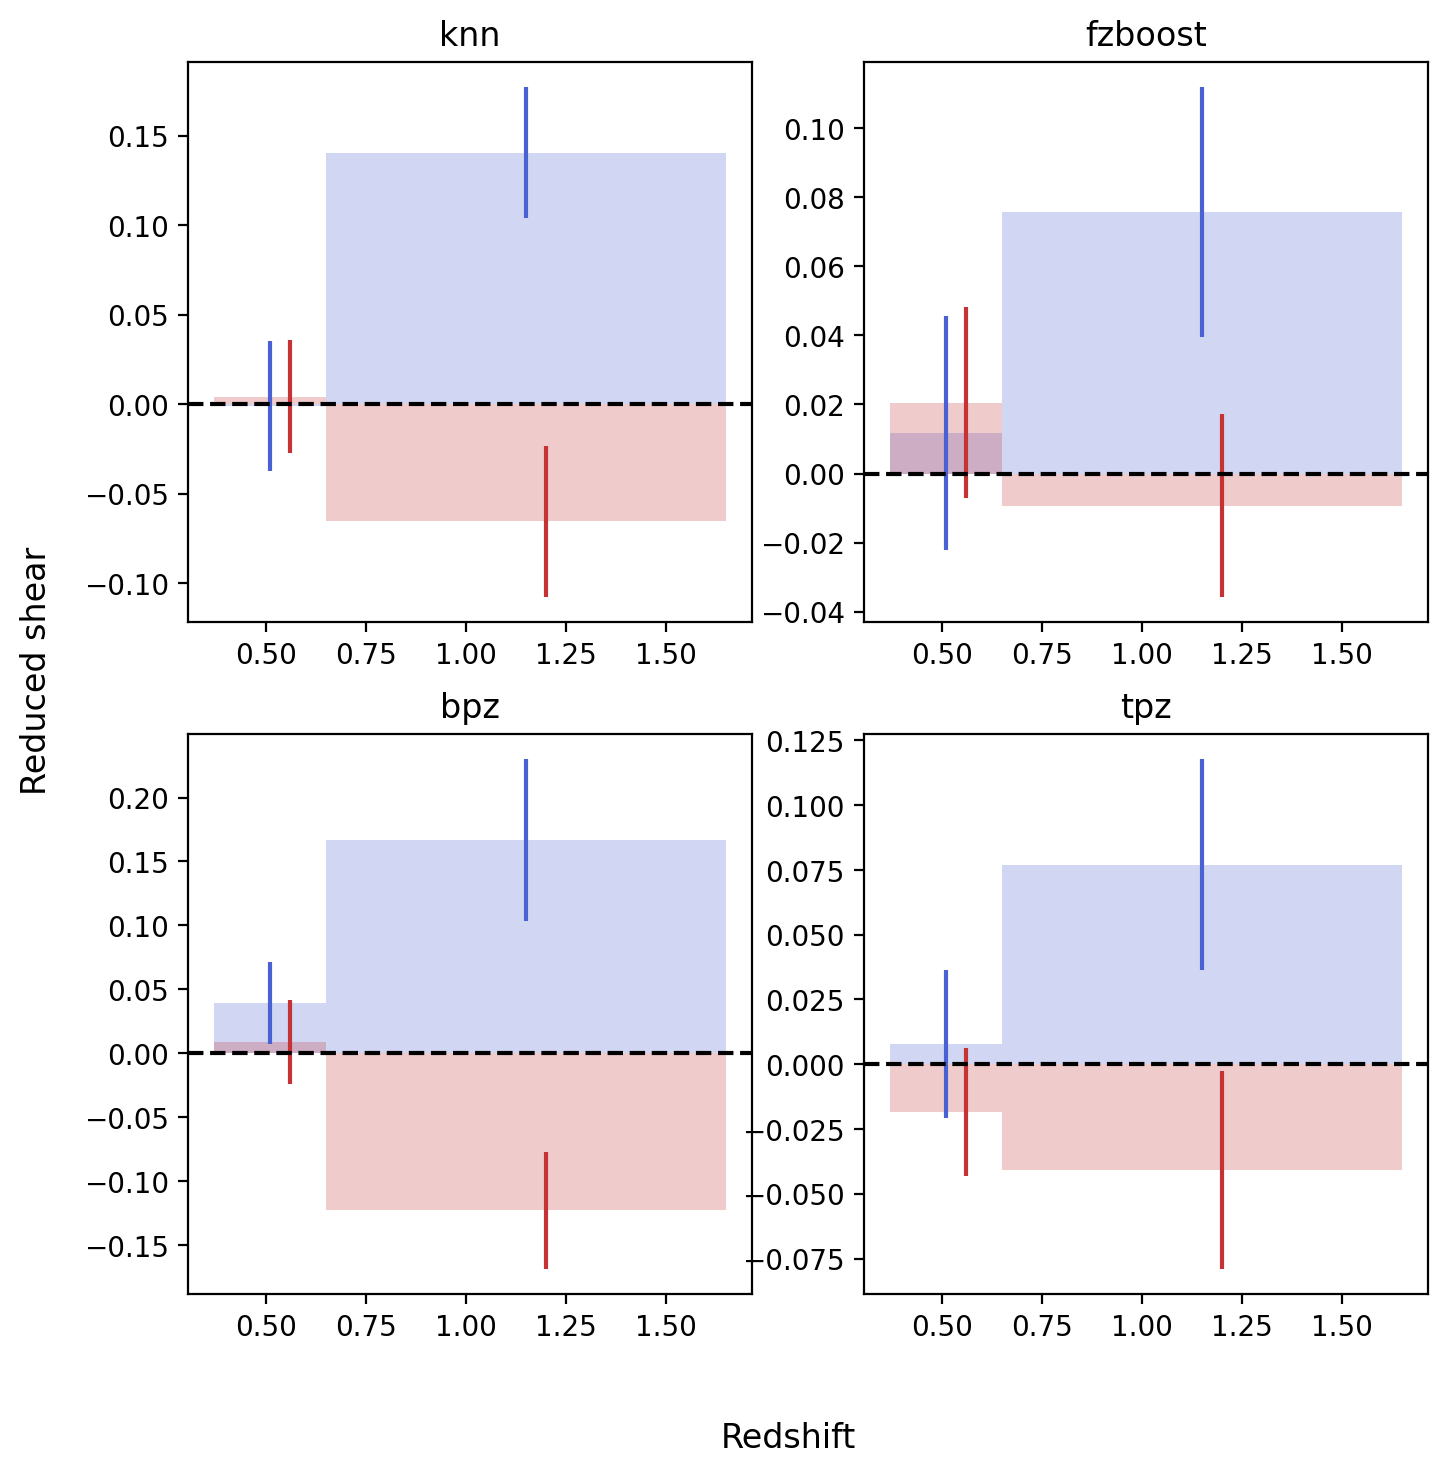

In [274]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51, 1.15], y=plot_means_t[i], yerr=plot_errs_t[i], color=cmap(0.05), ls='')
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51+0.05, 1.15+0.05], y=plot_means_x[i], yerr=plot_errs_x[i], color=cmap(0.95), ls='')
    axes[ix, iy].set_title(algos[i])
    # axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')
fig.supxlabel("Redshift")
fig.supylabel("Reduced shear")

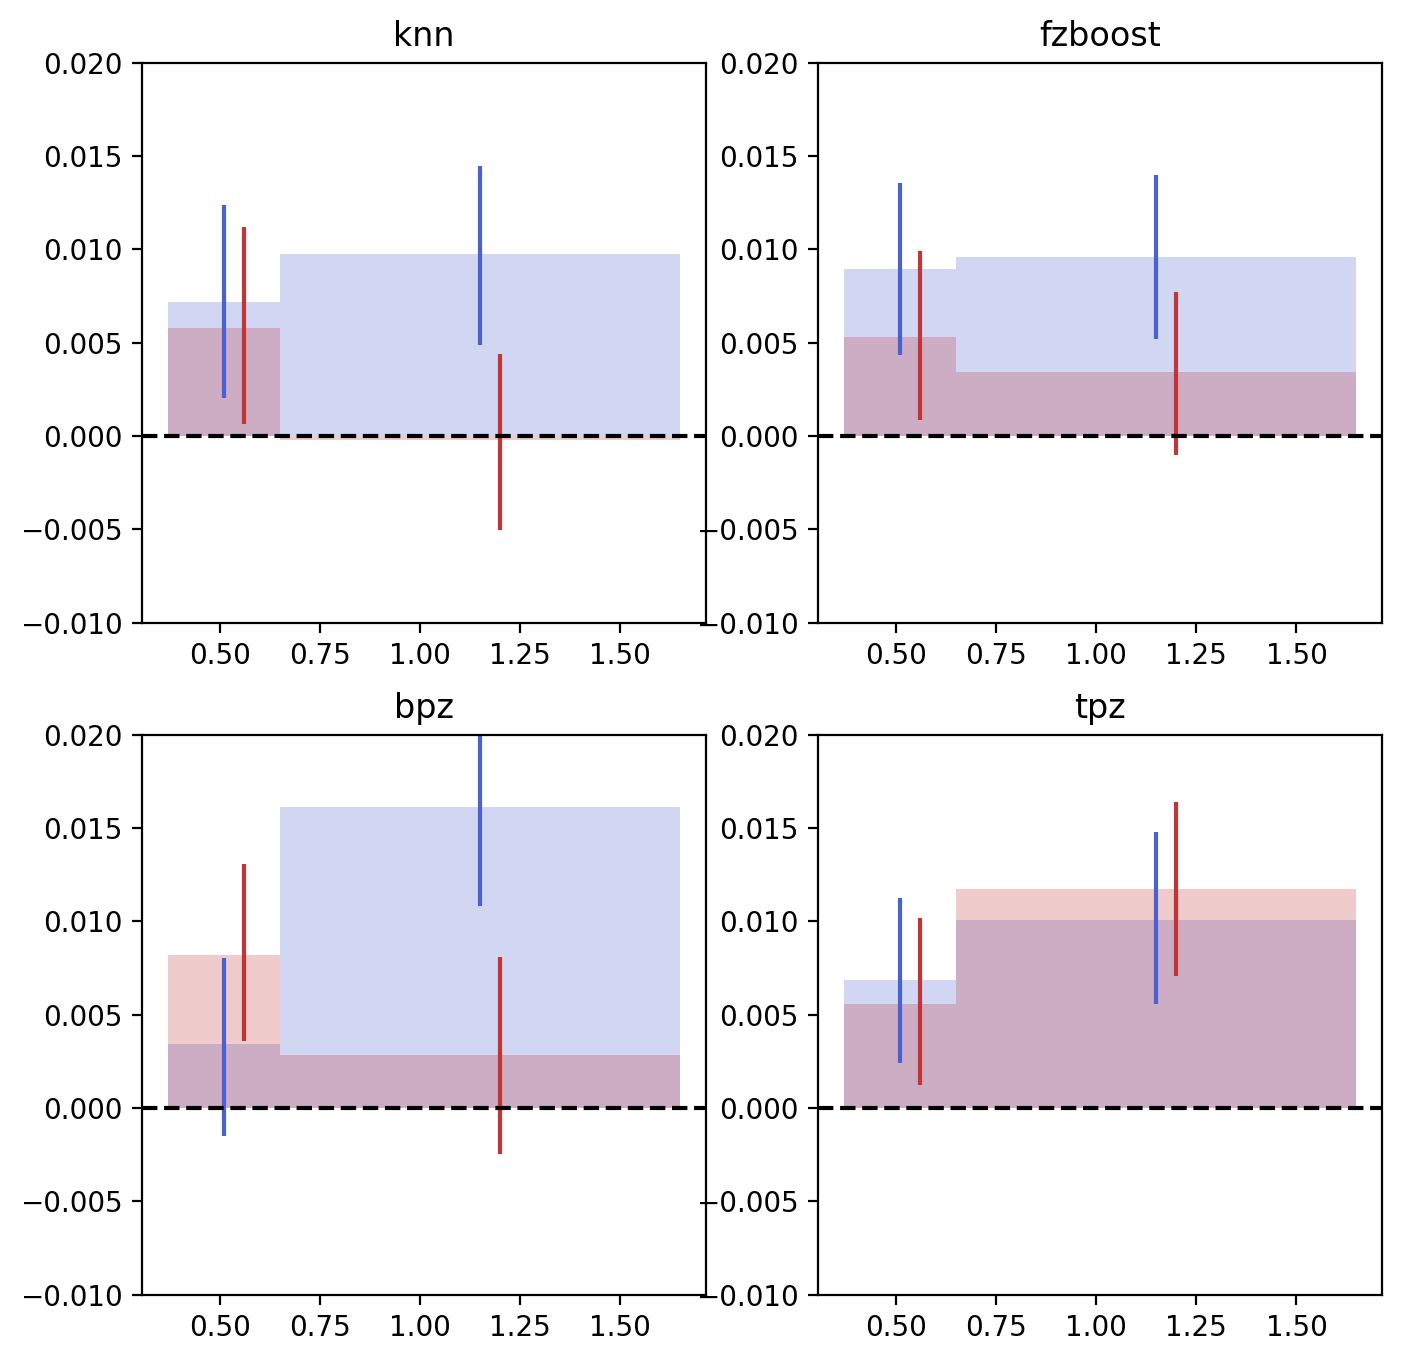

In [261]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].vlines([0.51, 1.15], ymin=plot_errs_t[i,:,0], ymax=plot_errs_t[i,:,1], color=cmap(0.05))
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].vlines([0.51+.05, 1.15+.05], ymin=plot_errs_x[i,:,0], ymax=plot_errs_x[i,:,1], color=cmap(0.95))
    axes[ix, iy].set_title(algos[i])
    axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')

## Data Summary Plot

Assuming the Butler cells were ran up-to creating the preclean_table

In [312]:
# clean_table2 = preclean_table[preclean_filt(preclean_table)]
clean_table = preclean_table[preclean_flux_filt(preclean_table)]

In [313]:
clean_table = apply_redsequence_noisy(clean_table, mag_lim=23.76, sigma=1)

/tmp/ipykernel_149/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:46: RuntimeWarning: invalid value encountered in log10
  gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:47: RuntimeWarning: invalid value encountere

In [314]:
clean_mask = get_masks(clean_table)
clean_table_masked = clean_table[clean_mask]

In [315]:
clean_table_psf = clean_table_masked[~clean_table_masked['i_iPSF_flag']]
clean_table_hsm = clean_table_psf[~clean_table_psf['i_hsmShapeRegauss_flag']]
# clean_table_extend = clean_table[clean_table['refExtendedness'] == 1]

In [330]:
wl_filt = get_wlfilt(clean_table_hsm, mag_lim=28, bright_lim=20, SNR=0, apply_extend=False)
wl_table = clean_table_hsm[wl_filt]

After WL cuts: 19012


In [331]:
# wl_table_bright = wl_table[wl_table['i_cModel_mag'] < 23.76]

In [332]:
# gstars = wl_table_bright[wl_table_bright['g_extendedness']==0]

# # for b in bands:
# #     print(b, np.sum(wl_table_bright[f'{b}_extendedness'] == 0))

In [333]:
wl_table_gal = wl_table[wl_table['refExtendedness'] == 1]

In [334]:
imag_table = wl_table_gal[wl_table_gal['i_cModel_mag'] < 23.76]
Nimag_table = len(imag_table)

In [335]:
SNR_cut14 = imag_table[imag_table['i_cModelFlux']/imag_table['i_cModelFluxErr'] > 14]
SNR_cut10 = imag_table[imag_table['i_cModelFlux']/imag_table['i_cModelFluxErr'] > 10]
Nsnr = len(SNR_cut10)
print((Nimag_table-Nsnr)/Nimag_table)

0.026556291390728477


In [336]:
rs_cut = SNR_cut10[~SNR_cut10['all_redseq']]

In [337]:
hist_bins = np.array([[i, i+0.25, i+.5, i+.76,] for i in range(18, 28)])

In [338]:
hist_bins = np.ravel(hist_bins)

[]

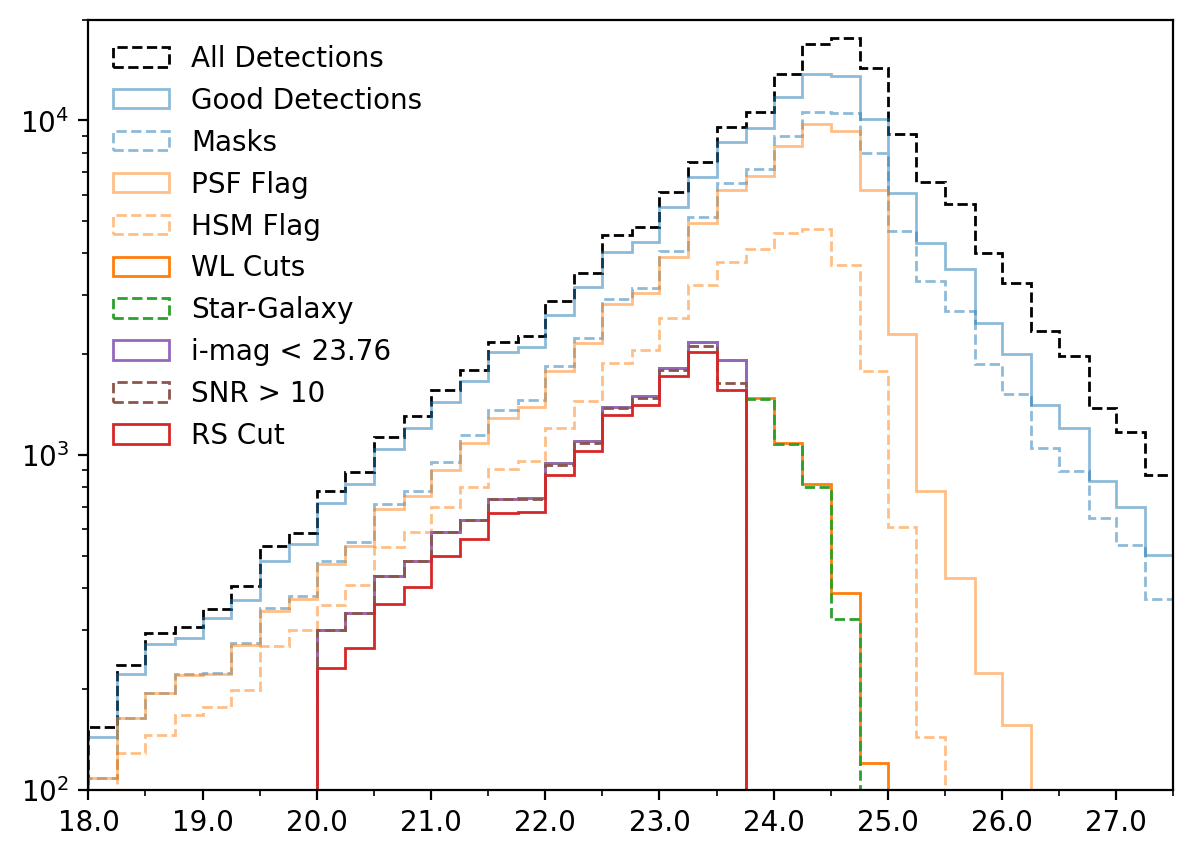

In [380]:
major_xticks = np.arange(18, 28.5, 1)
minor_xticks = np.arange(18.5, 28.5, 1)

cmap = cm.tab10

fig, ax = plt.subplots(1, figsize=(7,5))

# ax.hist(preclean_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="All Detections", color='k')
# ax.hist(clean_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="Good Detections", color=cmap(0), alpha=0.5, ls='--')
# ax.hist(clean_table_masked['i_cModel_mag'], bins=hist_bins, histtype='step', label="Masks", color=cmap(0), alpha=0.5)
# ax.hist(clean_table_psf['i_cModel_mag'], bins=hist_bins, histtype='step', label="PSF Flag", color=cmap(1), alpha=0.5, ls='--')
# ax.hist(clean_table_hsm['i_cModel_mag'], bins=hist_bins, histtype='step', label="HSM Flag", color=cmap(1), alpha=0.5, ls='-')
# ax.hist(wl_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="WL Cuts", color=cmap(1), ls='--')
# ax.hist(wl_table_gal['i_cModel_mag'], bins=hist_bins, histtype='step', label="Star-Galaxy", color=cmap(2))
# ax.hist(imag_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="i-mag < 23.76", color=cmap(4), ls='--')
# ax.hist(SNR_cut10['i_cModel_mag'], bins=hist_bins, histtype='step', label="SNR > 10", color=cmap(5))
# # plt.hist(SNR_cut14['i_cModel_mag'], range=(18, 28), histtype='step', bins=31, label="SNR > 14", color=cmap(4))
# ax.hist(rs_cut['i_cModel_mag'], bins=hist_bins, histtype='step', label="RS Cut", color=cmap(3), ls='--')

ax.hist(preclean_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="All Detections", color='k', ls='--')
ax.hist(clean_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="Good Detections", color=cmap(0), alpha=0.5)
ax.hist(clean_table_masked['i_cModel_mag'], bins=hist_bins, histtype='step', label="Masks", color=cmap(0), alpha=0.5, ls='--')
ax.hist(clean_table_psf['i_cModel_mag'], bins=hist_bins, histtype='step', label="PSF Flag", color=cmap(1), alpha=0.5)
ax.hist(clean_table_hsm['i_cModel_mag'], bins=hist_bins, histtype='step', label="HSM Flag", color=cmap(1), alpha=0.5, ls='--')
ax.hist(wl_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="WL Cuts", color=cmap(1))
ax.hist(wl_table_gal['i_cModel_mag'], bins=hist_bins, histtype='step', label="Star-Galaxy", color=cmap(2), ls='--')
ax.hist(imag_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="i-mag < 23.76", color=cmap(4))
ax.hist(SNR_cut10['i_cModel_mag'], bins=hist_bins, histtype='step', label="SNR > 10", color=cmap(5), ls='--')
# plt.hist(SNR_cut14['i_cModel_mag'], range=(18, 28), histtype='step', bins=31, label="SNR > 14", color=cmap(4))
ax.hist(rs_cut['i_cModel_mag'], bins=hist_bins, histtype='step', label="RS Cut", color=cmap(3))

ax.set_xticks(major_xticks, major_xticks, minor=False)
ax.set_xticks(minor_xticks, minor=True)
ax.set_ylim(1e2, 2e4)
ax.set_xlim(major_xticks[0], minor_xticks[-1])
ax.legend(frameon=False, ncol=1, loc='upper left', columnspacing=1)
ax.semilogy()
# ax.set_title("Abell 360 Field")

In [136]:
# preclean_ecdfs

In [307]:
clean_ecdfs, preclean_ecdfs = load_pz_photomdata(tracts=ecdfs_tracts, columns=ecdfs_object_req_cols)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [308]:
clean_ecdfs = apply_redsequence_noisy(clean_ecdfs, sigma=1, mag_lim=23.76)

/tmp/ipykernel_149/697460470.py:42: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:43: RuntimeWarning: invalid value encountered in log10
  ri_neg = -2.5*np.log10((table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:44: RuntimeWarning: invalid value encountered in log10
  gr_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - sigma*table['g_gaap1p0FluxErr'])/(table['r_gaap1p0Flux'] - sigma*table['r_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:46: RuntimeWarning: invalid value encountered in log10
  gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + sigma*table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + sigma*table['i_gaap1p0FluxErr']))
/tmp/ipykernel_149/697460470.py:47: RuntimeWarning: invalid value encountere

In [340]:
ec_mask = ecdfs_mask(clean_ecdfs)
clean_ecdfs_masked = clean_ecdfs[ec_mask]

In [341]:
clean_ecdfs_psf = clean_ecdfs_masked[~clean_ecdfs_masked['i_iPSF_flag']]
clean_ecdfs_hsm = clean_ecdfs_psf[~clean_ecdfs_psf['i_hsmShapeRegauss_flag']]

In [353]:
wl_filt = get_wlfilt(clean_ecdfs_hsm, mag_lim=28, bright_lim=20, SNR=0, apply_sep=False, apply_extend=False)
ecdfs_wl_table = clean_ecdfs_hsm[wl_filt]

After WL cuts: 73100


In [354]:
clean_ecdfs_extend = ecdfs_wl_table[ecdfs_wl_table['refExtendedness'] == 1]

In [355]:
ecdfs_imag_table = clean_ecdfs_extend[clean_ecdfs_extend['i_cModel_mag'] < 23.76]
Nimag_table = len(ecdfs_imag_table)

In [356]:
ecdfs_SNR_cut14 = ecdfs_imag_table[ecdfs_imag_table['i_cModelFlux']/ecdfs_imag_table['i_cModelFluxErr'] > 14]
ecdfs_SNR_cut10 = ecdfs_imag_table[ecdfs_imag_table['i_cModelFlux']/ecdfs_imag_table['i_cModelFluxErr'] > 10]
Nsnr = len(ecdfs_SNR_cut10)
print((Nimag_table-Nsnr)/Nimag_table)

0.004463696151712844


In [357]:
ecdfs_rs_cut = ecdfs_SNR_cut10[~ecdfs_SNR_cut10['all_redseq']]

[]

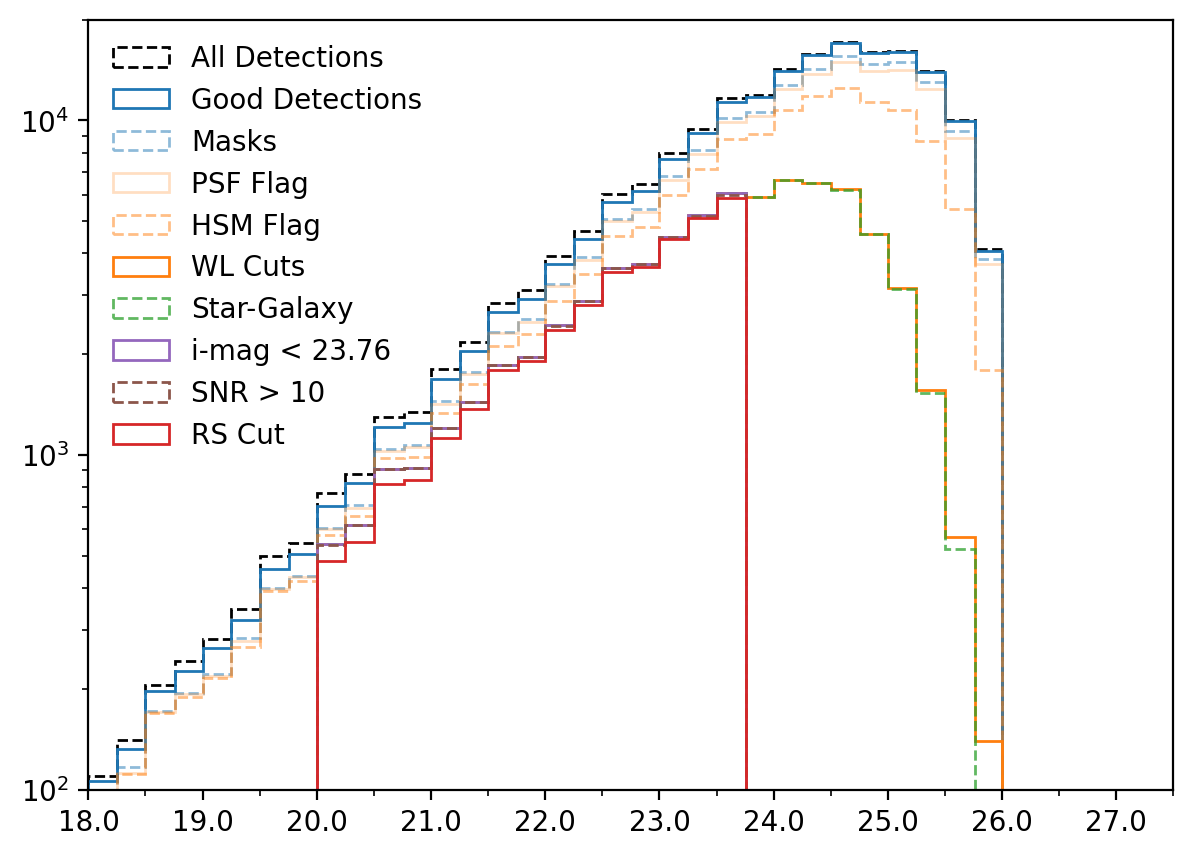

In [381]:
fig, ax = plt.subplots(1, figsize=(7,5))

major_xticks = np.arange(18, 28.5, 1)
minor_xticks = np.arange(18.5, 28.5, 1)

cmap = cm.tab10

ax.hist(preclean_ecdfs['i_cModel_mag'], bins=hist_bins, histtype='step', label="All Detections", color='k', ls='--')
ax.hist(clean_ecdfs['i_cModel_mag'], bins=hist_bins, histtype='step', label="Good Detections", color=cmap(0))
ax.hist(clean_ecdfs_masked['i_cModel_mag'], bins=hist_bins, histtype='step', label="Masks", color=cmap(0), alpha=0.5, ls='--')
ax.hist(clean_ecdfs_psf['i_cModel_mag'], bins=hist_bins, histtype='step', label="PSF Flag", color=cmap(1), alpha=0.25, ls='-')
ax.hist(clean_ecdfs_hsm['i_cModel_mag'], bins=hist_bins, histtype='step', label="HSM Flag", color=cmap(1), alpha=0.5, ls='--')
ax.hist(ecdfs_wl_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="WL Cuts", color=cmap(1))
ax.hist(clean_ecdfs_extend['i_cModel_mag'], bins=hist_bins, histtype='step', label="Star-Galaxy", color=cmap(2), alpha=0.75, ls='--')
ax.hist(ecdfs_imag_table['i_cModel_mag'], bins=hist_bins, histtype='step', label="i-mag < 23.76", color=cmap(4))
ax.hist(ecdfs_SNR_cut10['i_cModel_mag'], bins=hist_bins, histtype='step', label="SNR > 10", color=cmap(5), ls='--')
# plt.hist(SNR_cut14['i_cModel_mag'], range=(18, 28), histtype='step', bins=31, label="SNR > 14", color=cmap(4))
ax.hist(ecdfs_rs_cut['i_cModel_mag'], bins=hist_bins, histtype='step', label="RS Cut", color=cmap(3))

ax.set_xticks(major_xticks, major_xticks, minor=False)
ax.set_xticks(minor_xticks, minor=True)
ax.set_ylim(1e2, 2e4)
ax.set_xlim(major_xticks[0], minor_xticks[-1])
ax.legend(frameon=False, ncol=1, loc='upper left', columnspacing=1)
ax.semilogy()
# ax.set_title("ECDFS")

#### Playground